# Data Cleaning and Wrangling Project

##### Using the Kaggle's Titanic Dataset

In [1]:
import pandas as pd
import numpy as np
import random
import re
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import learning_curve, KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import datetime
import os
import shutil
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

# Introduction

This project is meant to showcase my data cleaning and data wrangling skills. I will be using the Titanic dataset from Kaggle.com. The description of this Kaggle challenge and the datasets used in this project can be found here: <a href="https://www.kaggle.com/competitions/titanic">The Titanic Dataset!</a><br><br>
The full Kaggle challenge involves predicting the survivors of the Titanic disaster contained in the test set by training a model on the outcomes of Titanic passengers in the labelled training set. In this notebook, I'll be focusing on strictly data cleaning and preparation of the data for usage in my model. With that, let's take a look at the dataset!

## A First Look at the Training Set

In [2]:
df_train = pd.read_csv("Titanic_Train_Original.csv", index_col = 0) # So the PassengerId Feature is used as row indices.
df_test = pd.read_csv("Titanic_Test_Original.csv", index_col = 0)

df_train.head(50)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


Let's explore the features of the training set using the data dictionary for this dataset written by the authors at Kaggle.com.

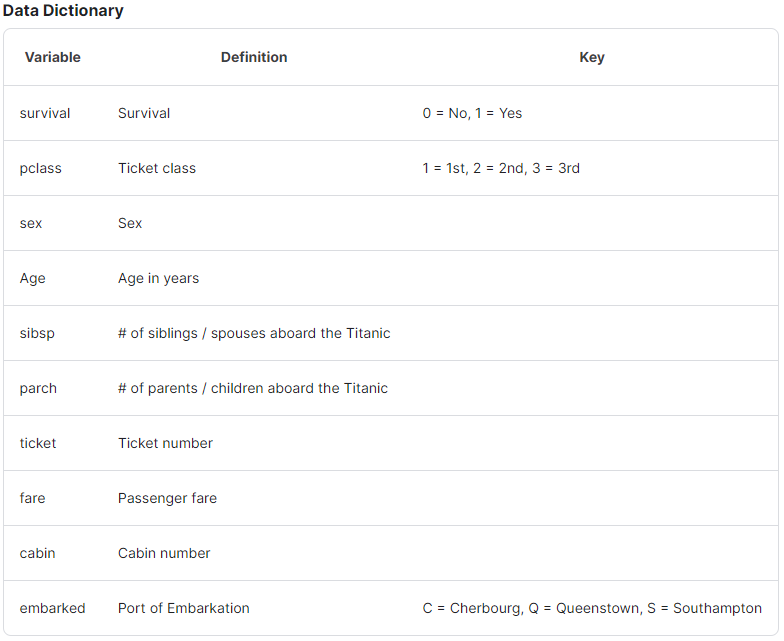

In [3]:
Image(filename="FeaturesDescriptions.png", width = 600)

So in summary, the training set has features as follows:<br>
<ul>
    <li>Five are text based and yield categorical or specific information about the passenger: Name, Sex, Ticket, Cabin, and Embarked.</li>
    <li>Two are numerical but are discrete and represent categories: Survived is binary, with 0 indicating the death of a passenger and 1 indicating survival. Pclass takes the values 1, 2, or 3, corresponding to the passenger's class aboard the ship.</li>
    <li>Four are numerical and quantitative: Age and Fare take continuous values greater than zero while Sibsp and Parch, both indicating the number of different types of relatives of the passenger aboard the ship, take integer values zero or larger.</li>
</ul>
Here it should be noted that a passenger's value for the Survived feature are labels! These values will train the Survival Prediction Model. <b>The training set will not have Survived values, thus while the training set has 11 features, the training set will only have ten.</b>

## Unique Value Counts for Categorical Features

In [4]:
categorical_columns = ["Pclass", "Name", "Sex", "Ticket", "Cabin", "Embarked"]
for c in categorical_columns:
    num_total = df_train[c].notna().count()
    num_unique = df_train[c].nunique()
    unique_sample = df_train[c].astype(str).unique().tolist()
    unique_sample = [i for i in unique_sample if i != "nan"]
    if len(unique_sample) > 3:
        unique_sample = unique_sample[:3]
    unique_sample.sort()
    unique_sample = "; ".join(unique_sample)
    print(f"* {c} has {num_unique} unique values out of {num_total} total values.")
    print(f"  * Sample: {unique_sample}")

* Pclass has 3 unique values out of 891 total values.
  * Sample: 1; 2; 3
* Name has 891 unique values out of 891 total values.
  * Sample: Braund, Mr. Owen Harris; Cumings, Mrs. John Bradley (Florence Briggs Thayer); Heikkinen, Miss. Laina
* Sex has 2 unique values out of 891 total values.
  * Sample: female; male
* Ticket has 681 unique values out of 891 total values.
  * Sample: A/5 21171; PC 17599; STON/O2. 3101282
* Cabin has 147 unique values out of 891 total values.
  * Sample: C123; C85; E46
* Embarked has 3 unique values out of 891 total values.
  * Sample: C; Q; S


Interestingly, the Ticket feature has less unique values than total values. This implies that some passengers share the same ticket. Let's add a feature called Ticket_Count to the dataset which indicates the number of people that are tied to a given ticket value.

# Fare vs. Fare per Passenger

In [5]:
df_train['Ticket_Count'] = df_train.groupby('Ticket')['Ticket'].transform('count')
df_test['Ticket_Count'] = df_test.groupby('Ticket')['Ticket'].transform('count')

Let's now find some passengers who share the same ticket, and see if there's anything unusual going on.

In [6]:
df_ticket = df_train[df_train["Ticket_Count"] > 1].copy()
df_ticket.sort_values(by=["Ticket_Count", "Ticket"], ascending = False, inplace = True)
ticket_key = df_ticket["Ticket"].iloc[0]
df_ticket[df_ticket["Ticket"] == ticket_key].head(df_ticket["Ticket_Count"].iloc[0])

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_Count
PassengerId,,,,,,,,,,,,
160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,7
181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,7
202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,7
325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,7
793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,7
847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,7
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,7


What's immediately obvious is that these passengers are in the same family, as they share the same SibSp and Parch values. What's interesting is that they also share the same Fare value too! This indicates that the Fare value is tied to the ticket, not to the individual passenger. Knowing the "per head" price for a given passenger will be useful for this project. Let's add a feature to capture this information to our dataset.

In [7]:
df_train['Fare_PerPassenger'] = df_train['Fare'] / df_train['Ticket_Count']
mean_fpp_train = df_train["Fare_PerPassenger"].mean()
df_train["Fare_PerPassenger"].fillna(mean_fpp_train, inplace = True)

df_test['Fare_PerPassenger'] = df_test['Fare'] / df_test['Ticket_Count']
mean_fpp_test = df_test["Fare_PerPassenger"].mean()
df_test["Fare_PerPassenger"].fillna(mean_fpp_test, inplace = True)

# A Quick Improvement: Making Sex Numerical

Since a passenger's sex is binary, the Sex feature can easily be made numerical, thereby making this feature cooperate better with quantitative models. Let's swap out values of "male" with 0 and values of "female" with 1.

In [8]:
df_train["Sex"] = df_train["Sex"].replace({"male":0,"female":1})
df_test["Sex"] = df_test["Sex"].replace({"male":0,"female":1})

# Diamond Data in the Rough: Utilizing the Name Feature

First names and surnames are unique to individuals, and therefore do not provide much useful predictive information on their own; however, Name values in this dataset are special: each carries an honorific title (ex. "Mr" or "Mrs") for a passenger. An honorific title can convey a great deal of information about one's age and socioeconomic status, especially in the early 20th century. For instance, a title of "Mrs" likely indicates that the passenger was female and of marriage age. A title of "Rev", short for Reverend, likely indicates that a passenger is male, middle-aged, and firmly within the middle class. A title of "Countess"? Perhaps royalty and someone who may have received special treatment aboard the Titanic.<br><br>

To extract the information encapsulated by one's honorific, we will add a new feature, NameTitle, to the dataset.

In [9]:
df_train["NameTitle"] = df_train["Name"].str.extract(r'\b(\w+)\.')
df_test["NameTitle"] = df_test["Name"].str.extract(r'\b(\w+)\.')

# NumFamily: The Total Number of Family Members Aboard

<b>SibSp</b> indicates a passenger's number of family members aboard the ship in a <i>horizontal</i> sense, being the sum of siblings plus a spouse if one is aboard along with the passenger. <b>Parch</b> is indicative of a passenger's relatives aboard in a <i>vertical</i> sense, as the sum of parents and children aboard with the passenger. Taken together, they can be considered as the total number of family members a passenger is accompanied by onboard. Let's add the <b>NumFamily</b> feature to our datasets to capture this sum.

In [10]:
df_train["NumFamily"] = df_train["SibSp"] + df_train["Parch"]
df_test["NumFamily"] = df_test["SibSp"] + df_test["Parch"]

# Missing Values in the Training Set

So far, we have made two text-based features quantitative, thus increasing our ability to use numerical models on our datasets. Now it is time to start addressing the values that are missing in our datasets. Let's see which features are missing values and how many they are missing.

In [11]:
train_size, test_size = len(df_train), len(df_test)
print(f"The training set has {train_size} total entries.")
print("Columns with missing values:")
for column in df_train.columns:
    null_values = df_train[column].isnull().sum()
    if null_values > 0:
        print(f"  * {column}:  {null_values} missing values.")

The training set has 891 total entries.
Columns with missing values:
  * Age:  177 missing values.
  * Cabin:  687 missing values.
  * Embarked:  2 missing values.


Looks like we have two features that are significantly lacking in data! It is common knowledge that age played an important role in survival of the Titanic disaster — and the training set is missing 19.9% of these values! Moreover, the cabin feature indicates where a passenger stayed aboard the ship, another crucial piece of information for this task and the training set is missing 77.1% of these values!<br><br>In order to make proper survival predictions, these missing values must be addressed, either by an estimation method or by making the best of the information we do have for these passengers. 

## Clean Records vs. Missing Records: Is the Completion of a Passenger's Information Correlated with Their Survival?

It would be reasonable to suppose that passengers with complete information (no missing feature values) had a higher survival rate than passengers with incomplete records. Among several reasons for making this assumption is simply <b>Survivorship Bias</b>. It is possible that passenger records were improved upon or made complete <i>after</i> the disaster especially given how momentous the event was. In this case, those who survived would have been able to provide information that was previously missing to those who held/collected passenger data. Those who perished would not have been able to provide their information. Whether or not survivorship bias is the root cause for our missing data, it is valuable nonetheless to check if there is a significant difference in survival rate between those with complete records and those without.

Surviviorship among Entries With and Without Null Values:
* 183 entries with no null values. Mean survival rate: 67.2%
* 708 entries with null values. Mean survival rate: 30.9%


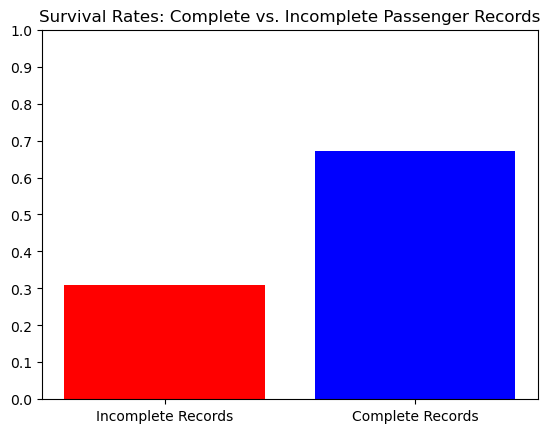

In [12]:
df_info = df_train.copy()
df_info["CompleteInfo"] = df_info.notnull().all(axis=1)
complete_info_count = df_info["CompleteInfo"].value_counts()
means = df_info.groupby('CompleteInfo')['Survived'].mean()
print("Surviviorship among Entries With and Without Null Values:")
print(f"* {complete_info_count.loc[True]} entries with no null values. Mean survival rate: {round(means.loc[True]*100,1)}%")
print(f"* {complete_info_count.loc[False]} entries with null values. Mean survival rate: {round(means.loc[False]*100,1)}%")

fig, ax = plt.subplots()
bar_colors = ['red', 'blue']
bar_labels = ['Incomplete Records', 'Complete Records']
ax.bar(bar_labels, means, color=bar_colors)
ax.set_ylim(0.0, 1.0)
ax.set_yticks([i/10 for i in range(11)])
ax.set_title('Survival Rates: Complete vs. Incomplete Passenger Records')
plt.show()

This seems to be a very large difference in the survivorship of those with complete records compared to those without. Let's verify the statistical significance! Let $n_1$ be the number of passengers in the training set with no null values. Likewise, let $n_2$ be the number in the training set who are missing a value for at least one feature. Additionally, let $p_1$ be the proportion of those aboard with no missing feature values and let $p_2$ be the same proportion for those who are missing at least one feature value.<br><br>
$$n_1=183$$
$$n_2=708$$
$$p_1 \approx 67.21%$$
$$p_2 \approx 30.93%$$<br>
Let's check the statistical significance of the difference in survival rates, using a <i>95% confidence interval</i>. First we compute the standard error, $SE$.<br><br>
$$SE=\sqrt{\frac{p_1(1-p_1)}{n_1} + \frac{p_2(1-p_2)}{n_2}}=\sqrt{\frac{0.6721(1-0.6721)}{183}+\frac{0.3093(1-0.3093)}{708}} \approx 0.03881$$<br>
For a 95% confidence interval, the associated Z-score is approximately: $Z=1.96$, and thus the confidence interval $CI$ is:<br><br>
$$CI=(p_1-p_2) \mp Z \cdot SE=(0.6721-0.3093) \mp 1.96 \cdot 0.03881=[0.28673,0.43887]$$<br>
This means that in the full population, we can be 95% certain that the difference in survival rates between those with complete records and those without is between ~28.7% and ~43.9%. Even with a difference of 28.7% (the lower boundary) between the two cohorts, the difference in survival is massive. Thus, its important to keep an eye on the passengers with/without null values, and perhaps incorporate this information into the final prediction model.<br><br>

Moreover, given just how significant difference is, it is very reasonable to assume that this trend will persist in the test set. We will add a CompleteInfo feature to the dataset, with 0 indicating the presence of null values for an entry and 1 indicating full records for that entry.

In [13]:
df_train["CompleteInfo"] = df_train.notnull().all(axis=1)
df_test["CompleteInfo"] = df_test.notnull().all(axis=1)
df_train["CompleteInfo"] = df_train["CompleteInfo"].replace({False:0,True:1})
df_test["CompleteInfo"] = df_test["CompleteInfo"].replace({False:0,True:1})

## Estimating the Two Missing Embarked Values

### Mode: A Very Simple Estimation

Two out of 891 Embarked values are missing in the training set. Using a similar 95% confidence interval approach as above, we can get an estimate of the number of missing embarked values in the test set. Let $N$ be the size of the training set and $P$ be the proportion of missing values in $N$.<br><br>
$$N=891$$
$$P=\frac{2}{891} \approx 0.0024$$<br>
Using the same formula for standard error, we have:<br><br>
$$SE=\sqrt{\frac{P(1 - P)}{N}}=\sqrt{\frac{\frac{2}{891}(1-\frac{2}{891})}{891}} \approx 0.00159$$<br>
This gives a 95% confidence interval of:<br><br>
$$CI=P \mp Z \cdot SE=\frac{2}{891} \mp 1.96 \cdot 0.00159 \approx [-0.00086, 0.00535]$$
Let $N'$ denote the size of the test set.<br><br>
$$N'=418$$<br>
Multiplying the confidence interval by $N'$, and rounding the values to the nearest integer greater than or equal to zero gives:<br><br>
$$N' \cdot CI=418 \cdot [-0.00086, 0.00535] \approx [0, 2]$$<br>
This means that we can be 95% certain that the number of missing Embarked values in the test set is no greater than 2, less than 0.5% the size of the test set. With so few missing Embarked values, it is reasonable to assume that a highly sophisticated method for estimating the missing Embarked values will do little to improve the predictive power of the model, and moreover, introduces the risk of overfitting this parameter within the model. Therefore, for this feature, simplicity is key. We will assign the mode Embarked value of the dataset to the missing values.

In [14]:
mode_embarked = df_train["Embarked"].mode()[0]
df_train["Embarked"].fillna(mode_embarked, inplace=True)

mode_embarked = df_test["Embarked"].mode()[0]
df_test["Embarked"].fillna(mode_embarked, inplace=True)

## Estimating Missing Age Values

The training set is missing 177 values for the Age feature — that accounts for approximately 20% of the training set. Age values are quantitative, continuous, and critically important for the ultimate prediction task of this project. Therefore, we devise a way to make high-quality estimations to fill in our missing values. Let's take stock of what we know about Age values and what information we have readily available in our training set.<br><br>

First, we can recognize that predicting age values falls is a regression task. Since age values are continuous, the task of predicting them requires us to assemble a parametric model. So what can we use as parameters?<br><br>

In order to perform regression, the parameters we employ in our model must be numerical and quantitative, rather than categorical.<br>
<ul>
    <li>Let's start by looking at the Pclass parameter, which stradles this threshold. While its values indicate a given passenger's class, a category that the passenger belonged to, these values do have quantitative merit. First class, a Pclass value of 1, is in some real sense "above" classes two and three. These values can easily be interpreted as rankings.</li>
    <li>Next comes the Sex feature: Earlier, we replaced values of "male" with 0 and "female" with +1. Since Sex only takes binary values, we can definitely interpret it as numerical.</li>
    <li>SibSp and Parch are unequivocally numerical. Additionally, these features provide information about the family structure of a passenger; a key indicator of age.</li>
    <li>Fare_PerPassenger is purely quantitative. A passenger's fare price is indicative of their socioeconomic status, and thereby accumulated wealth. Since wealth takes time to accumulate, it is quite reasonably to assume that it might be an indicator of one's age.</li>
    <li>Lastly, we have the albatross of our parameter set: NameTitle. Honorific titles are purely categorical; however, they reveal much about a passengers station in life. Perhaps we can apply a creative method to derive numerical data from NameTitle values.</li>
</ul>
And thus we have the parameter set with which we will attempt to estimate missing ages: Pclass, Sex, SibSp, Parch, Fare_PerPassenger, and NameTitle. Since we are including NameTitle; however, we cannot yet proceed to selecting our regression model. We will first come up with a way to extract numbers out of names. 

### Two Approaches for Wrangling the NameTitle Feature

We will employ two seperate approaches for handling the categorical, text-based values in the NameTitle feature.<br>
<ol>
    <li>The first approach is the more straightforward one. We will simply encode the NameTitle value for each entry by adding a feature to our training set for each unique value contained in NameTitle. We can do this via dummy variables. If a passenger carries a NameTitle of "Mr", for instance, his entry will have a 1 in the column corresponding to "Mr", and a value of 0 in all other dummy variable columns. While very easy to implement, this approach does have drawbacks, the largest of which is that it will cause the dimensionality of our dataset to rapidly ballon to nearly three times its original size.</li>
    <li>The second approach is a bit more sophisticated, but will not alter the dimensionality of our data. We will use the Smoothed Target Encoding method to replace NameTitle values with an amalgum of average Age values. To explain this approach, we will introduce some notation. Each entry $x$ in our dataset belongs to some cohort, $c$ according to the entry's NameTitle value. For the sake of example, let's define cohort $c$ as the one that corresponds to having a NameTitle value of "Rev" We can compute the mean Age value of cohort $c$ by taking the mean of the ages of all members of the cohort. Let's denote this mean as $\mu_{c}$. We can also easily obtain the mean Age of the entire dataset. Let's call this term $\mu_{D}$. According to the size of cohort $c$ and according to a regularization hyperparameter that we are free to define as we would like, we can define two weights, $w_1$ and $w_2$. $w_1$ and $w_2$ are weight values, where $w_1 + w_2 = 1$. We can then compute a replacement value, $r$, for the NameTitle value of x as follows: $r=w_{1} \cdot \mu_{c} + w_{2} \cdot \mu_{D}$</li>
</ol><br>
We can run these two approaches in tandem and decide which type of encoding to use for predictions once we evaluate their respective performances in conjunction with the regression models that are compared. To get started in this process, we will first segment our training dataset into two smaller sets; the first containing only those entries of the training set with age values known from the beginning, and the second set containing only those entries of the dataset that are missing age values. Next, we will obtain dummy variable encodings to augment the training set and smoothed target encodings to replace NameTitle values. 

In [15]:
df_age_prediction = df_train[["Age", "Pclass", "Sex", "SibSp", "Parch", "Fare_PerPassenger", "NameTitle"]].copy()

df_known_ages = df_age_prediction[df_age_prediction["Age"].notnull()].copy()
df_unknown_ages = df_age_prediction[df_age_prediction["Age"].isnull()].copy()
df_unknown_ages.drop("Age", axis = 1, inplace = True)

# Dummy variable encoding for both dataframes
df_known_ages_dummy = pd.get_dummies(df_known_ages, columns=["NameTitle"])
df_unknown_ages_dummy = pd.get_dummies(df_unknown_ages, columns=["NameTitle"])

# Smoothed Target Encoding
target_enc = TargetEncoder(smoothing=True)
df_known_ages["NameTitle"] = target_enc.fit_transform(df_known_ages["NameTitle"], df_known_ages["Age"])

#### Training Candidate Models

With numerical values now generated to stand in for categorical NameTitle values, we will now consider three candidate regression models to evaluate.<br><br>

<b>Option 1: Linear Regression</b><br>
In Linear Regression, we try to find a weight vector $w$ that optimally fits the examples $x^{(i)} \in \mathbb{R^D}$ in the training set $X$ to a linear model:
$$y=\displaystyle\sum_{j=0}^{D}x^{(i)}_{j} \cdot w_{j}$$
In this case, the number of examples $N$ within $X$ is far greater than the dimensionality $D$ of an example $x^{(i)}$, so the optimal vector $w$ must be found using gradient descent. This involves minimizing the squared difference between the model's predictions, $y$, and the true value $\hat{y^{(i)}}$ for every example in $X$. Finding the optimal values $w_j$ for each component of vector $w$ is done by iteratively updating each component after finding the derivative of the cost function $C(w)$ with respect to that component:
$$w_j \leftarrow w_j - \alpha \frac{\partial}{\partial w_j} C(w) \text{, where } \alpha \text{ is the learning rate}$$<br><br>

<b>Option 2: Decision Tree Regression</b><br>
Decision tree regression is another way to estimate continuous variables, like ages. Here's a brief summary of how it works:<br>
<ol>
    <li>A training example is sent to the root of the tree, and a binary question is asked, such as "Is this example's Pclass value equal to 1?".</li>
    <li>Based on the outcome, the example moves to the next branch of the tree where another binary question is asked of it, and so on.</li>
    <li>Once the example reaches the end of the tree, the predicted value is computed by taking the mean of the target values of the other members who reside on this final leaf.</li>
</ol>
Below is an example diagram for an example passenger with the following characteristics:<br>
<ul>
    <li>Has a Pclass value of 1</li>
    <li>Who is male</li>
    <li>Who has a SibSp value of 0</li>
    <li>Who has a Parch value of 0</li>
    <li>Whose fare was less than 50</li>
    <li>Who has a NameTitle of Mr.</li>
</ul>
There are 39 members of the training set who also have these characteristics, and their mean age is about 46, thus this example is predicted to have an age of about 46.

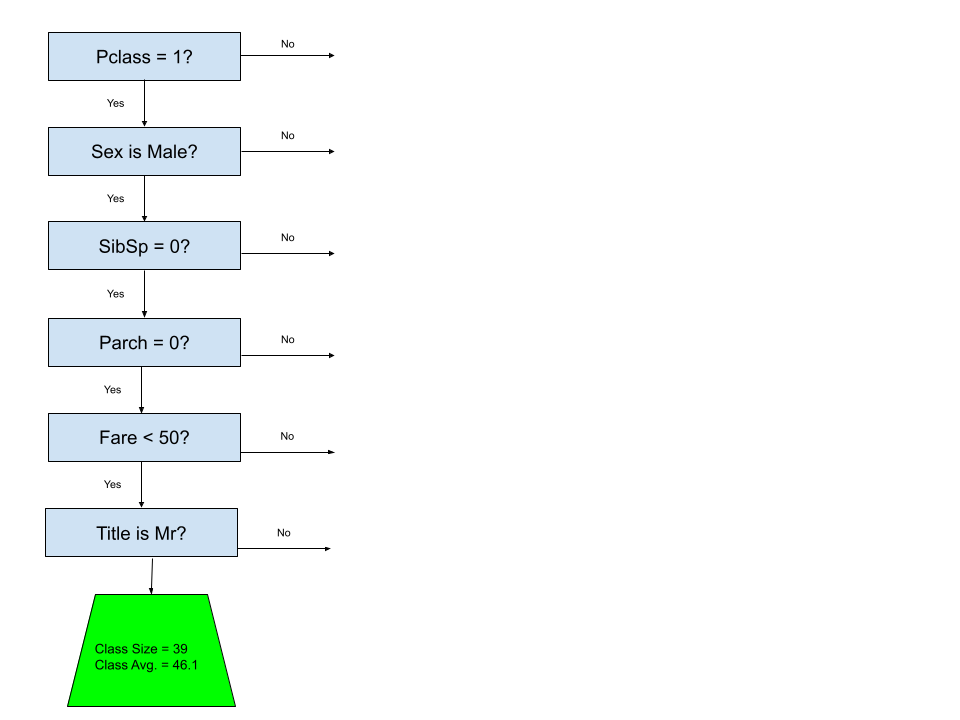

In [16]:
Image("DecisionTreeRegression.png", width = 650)

<b>Option 3: Random Forest Regression</b><br>
Finally, Random Forest Regression is quite similar to Decision Tree Regression; however, instead of a single decision tree, it uses several of them, each varying slightly from the others. The resulting prediction for an example is the mean of each tree's prediction. This model leverages randomness to mitigate the risk of overfitting commonly associated with decision tree regression.

### Tuning Hyperparameters for Six Candidate Model-Encoding Pairs

We have six model-encoding pairs that we will compare: two encoding approaches for each of the three models. Let's optimize the hyperparameters for each of these approaches using Scikit-Learn's Grid Search function. Though this can be a lengthy process, we can reduce the number of model-encoding searches from 6 to 4 as Linear Regression doesn't have meaningful hyperparameters to tune.

In [17]:
def tune_hyperparameters(model_tuning_list, trial_number, cv = 5):
    total_computation_start = datetime.datetime.now()
    print(f"Trial {trial_number} started at {total_computation_start}")
    print("_"*80)
    results_dict = {"Trial" : trial_number}
    for mt in model_tuning_list:
        model_computation_start = datetime.datetime.now()
        model_results_dict = {}
        model_name = mt[0]
        model = mt[1]
        X_train = mt[2]
        y_train = mt[3]
        p_grid = mt[4]
        model_results_dict["Search Space"] = p_grid
        print(f"Finding Hyperparameters for {model_name}. Hyperparameter search space is...")
        for item in list(p_grid.items()):
            print(f"* {item[0]}: {item[1]}")
        print()
        grid_search = GridSearchCV(estimator=model,
                                   param_grid=p_grid,
                                   cv=cv,
                                   scoring='neg_mean_squared_error',
                                   verbose=3,
                                   n_jobs=-1
                                  )
        grid_search.fit(X_train, y_train)
        print()
        best_params = grid_search.best_params_
        model_results_dict["Best Hyperparameters"] = best_params
        print(f"Best hyperparameters for {model_name}...")
        for item in best_params.items():
            print(f"* {item[0]}: {item[1]}")
        print()
        model_computation_end = datetime.datetime.now()
        model_computation_duration = (model_computation_end - model_computation_start).total_seconds()
        model_results_dict["Tuning Duration"] = model_computation_duration
        results_dict[model_name] = model_results_dict
        print(f"Hyperparameter Tuning for {model_name} took {round(model_computation_duration,1)} seconds.")
        print("_"*80)
    total_computation_end = datetime.datetime.now()
    total_computation_duration = (total_computation_end - total_computation_start).total_seconds()
    results_dict["Trial Duration"] = total_computation_duration
    print(f"Trial {trial_number} took {round(total_computation_duration,1)} seconds.")
    return results_dict

def save_tuning_log(results_dict, task_name):
    trial_number = results_dict["Trial"]
    fname = f"Hyperparameter_Tuning_for_{task_name}_Trial{trial_number}.txt"
    tuning_log = f"TRIAL {trial_number}" + "\n"
    for item in list(results_dict.items()):
        if (item[0] == "Trial") or (item[0] == "Trial Duration"):
            pass
        else:
            tuning_log += f"* Model: {item[0]}" + "\n"
            search_space = item[1]["Search Space"]
            tuning_log += "  * Search Space:" + "\n"
            for ss_item in list(search_space.items()):
                tuning_log += f"    * {ss_item[0]}: {ss_item[1]}" + "\n"
            best_params = item[1]["Best Hyperparameters"]
            tuning_log += "  * Best Hyperparameters:" + "\n"
            for bp_item in list(best_params.items()):
                tuning_log += f"    * {bp_item[0]}: {bp_item[1]}" + "\n"
            model_tuning_duration = item[1]["Tuning Duration"]
            tuning_log += f"  * Tuning Duration: {model_tuning_duration}" + "\n"
    tuning_log += f"* Total Trial Duration: {results_dict['Trial Duration']} seconds"
    with open(fname, "w") as f:
        f.write(tuning_log)
        
def centralize_tuning_logs(first_trial, last_trial, task_name, move_to = None):
    fnames = [f"Hyperparameter_Tuning_for_{task_name}_Trial{i}.txt" for i in range(first_trial, last_trial + 1)]
    full_tuning_log_string = "_"*80+"\n"
    for fn in fnames:
        with open(fn, "r") as f:
            full_tuning_log_string += f.read()
        full_tuning_log_string += "\n"+"_"*80+"\n"
    with open(f"Hyperparameter_Tuning_for_{task_name}_All_Trials.txt", "w") as f:
        f.write(full_tuning_log_string)
    if move_to is not None:
        parent_dir = os.getcwd()
        move_to_dir = parent_dir + "\\" + move_to
        for fn in fnames:
            shutil.move(parent_dir + "\\" + fn, move_to_dir + "\\" + fn)

In [19]:
X_dummy = df_known_ages_dummy.drop(columns="Age")
y_dummy = df_known_ages_dummy["Age"]
X_tgt = df_known_ages.drop(columns=["Age"])
y_tgt = df_known_ages["Age"]

DTR_dummy = ("DecTrReg w/ DmyVarEnc",
             DecisionTreeRegressor(),
             X_dummy,
             y_dummy,
             {
                 "max_depth" : [7],
                 "max_features" : [7],
                 "min_samples_leaf" : [4],
                 "min_samples_split" : [27]
             })

DTR_tgt = ("DecTrReg w/ TgtEnc",
             DecisionTreeRegressor(),
             X_tgt,
             y_tgt,
             {
                 "max_depth" : [3],
                 "max_features" : [5],
                 "min_samples_leaf" : [14],
                 "min_samples_split" : [34]
             })

RFR_dummy = ("RdmFrstReg w/ DmyVarEnc",
          RandomForestRegressor(),
          X_tgt,
          y_tgt,
          {
              "max_depth" : [6],
              "max_features" : [2],
              "min_samples_leaf" : [1],
              "min_samples_split" : [14],
              "n_estimators" : [65]
          })

RFR_tgt = ("RdmFrstReg w/ TgtEnc",
          RandomForestRegressor(),
          X_tgt,
          y_tgt,
          {
              "max_depth" : [5],
              "max_features" : [4],
              "min_samples_leaf" : [4],
              "min_samples_split" : [17],
              "n_estimators" : [10]
          })

model_tuning_list = [DTR_dummy, DTR_tgt, RFR_dummy, RFR_tgt]

# Uncomment to Run Hyperparameter Tuning for Models
# trial_number = 6
# trial_results = tune_hyperparameters(model_tuning_list, trial_number, cv = 5)
# save_tuning_log(trial_results, "Age_Prediction")

# Uncomment to consolidate trials into single file
# centralize_tuning_logs(1, trial_number, "Age_Prediction", move_to = "Old Tuning Logs")

with open("Hyperparameter_Tuning_for_Age_Prediction_All_Trials.txt", "r") as f:
    print(f.read())

________________________________________________________________________________
TRIAL 1
* Model: DecTrReg w/ DmyVarEnc
  * Search Space:
    * max_depth: [1, 2, 3, 4, 5, 6, 7]
    * max_features: [1, 2, 3, 4, 5, 6]
    * min_samples_leaf: [1, 2, 5, 10, 20]
    * min_samples_split: [2, 5, 10, 15, 20, 25, 30]
  * Best Hyperparameters:
    * max_depth: 6
    * max_features: 5
    * min_samples_leaf: 2
    * min_samples_split: 25
  * Tuning Duration: 121.764788
* Model: DecTrReg w/ TgtEnc
  * Search Space:
    * max_depth: [1, 2, 3, 4, 5, 6, 7]
    * max_features: [1, 2, 3, 4, 5, 6]
    * min_samples_leaf: [1, 2, 5, 10, 20]
    * min_samples_split: [2, 5, 10, 15, 20, 25, 30]
  * Best Hyperparameters:
    * max_depth: 3
    * max_features: 5
    * min_samples_leaf: 20
    * min_samples_split: 25
  * Tuning Duration: 93.65784
* Model: RdmFrstReg w/ DmyVarEnc
  * Search Space:
    * max_depth: [1, 5, 9]
    * max_features: [1, 4, 7]
    * min_samples_leaf: [1, 8, 15, 22]
    * min_samples_sp

In [20]:
opt_models_enc = {
    'LinReg w/ DmyVarEnc' : {"model_type" : LinearRegression(), "X_train" : X_dummy, "y_train" : y_dummy},
    'DecTrReg w/ DmyVarEnc' : {"model_type" : DecisionTreeRegressor(max_depth = 7, max_features = 7, min_samples_leaf = 4,
                                                                    min_samples_split = 27), "X_train" : X_dummy,
                               "y_train" : y_dummy},
    'RdmFrstReg w/ DmyVarEnc' : {"model_type" : RandomForestRegressor(max_depth = 6, max_features = 2, min_samples_leaf = 1,
                                                                      min_samples_split = 14, n_estimators = 65),
                                 "X_train" : X_dummy, "y_train" : y_dummy},
    'LinReg w/ TgtEnc' : {"model_type" : LinearRegression(), "X_train" : X_tgt, "y_train" : y_tgt},
    'DecTrReg w/ TgtEnc' : {"model_type" : DecisionTreeRegressor(max_depth = 3, max_features = 5, min_samples_leaf = 14,
                                                                 min_samples_split = 34), "X_train" : X_tgt, "y_train" : y_tgt},
    'RdmFrstReg w/ TgtEnc' : {"model_type" : RandomForestRegressor(max_depth = 5, max_features = 4, min_samples_leaf = 4,
                                                                   min_samples_split = 17, n_estimators = 10),
                              "X_train" : X_tgt, "y_train" : y_tgt}
}

#### Identifying Top-Performing Model-Encoding Pair

With two approaches to encoding NameTitle values and three candidate regression models, there will be six total model-encoding pairs to evaluate. We will then conduct a learning curve analysis with cross-validation to assess the performance of each pair and select the top-performing model-encoding pair to predict the missing age values in our datasets. The selection criteria for the top performing model are as follows:<br>
<ol>
    <li><b>Low MSE Test Score:</b> A low MSE test score indicates strong performance in cross-validation. This means that the model-encoding pair generalizes its performance well on new data. (Note that a low score in this context refers to a score that is close to zero. Though scores are negative, we are looking for models that have scores with the smallest absolute value.)</li>
    <li><b>Convergence between training performance and cross-validation performance:</b> We are looking for models that have training scores and test scores that trend towards convergence as training set size increases. A trend toward convergence indicates that the model is less prone to overfitting and that a good balance between learning and regularization is established.</li>
    <li><b>Smoothness of score trends:</b> While, in general, convergence between training scores and test scores is good, trend lines that seem to nearly crash into one another and then recoil is a red flag. Turbulent score trends indicate that a model is overly sensitive to the number of training examples.</li>
</ol>

Let's take a look at how each model-encoding pair performed! Here are six plots displaying how each pair performed in training and cross-validation as the number of training examples increased.

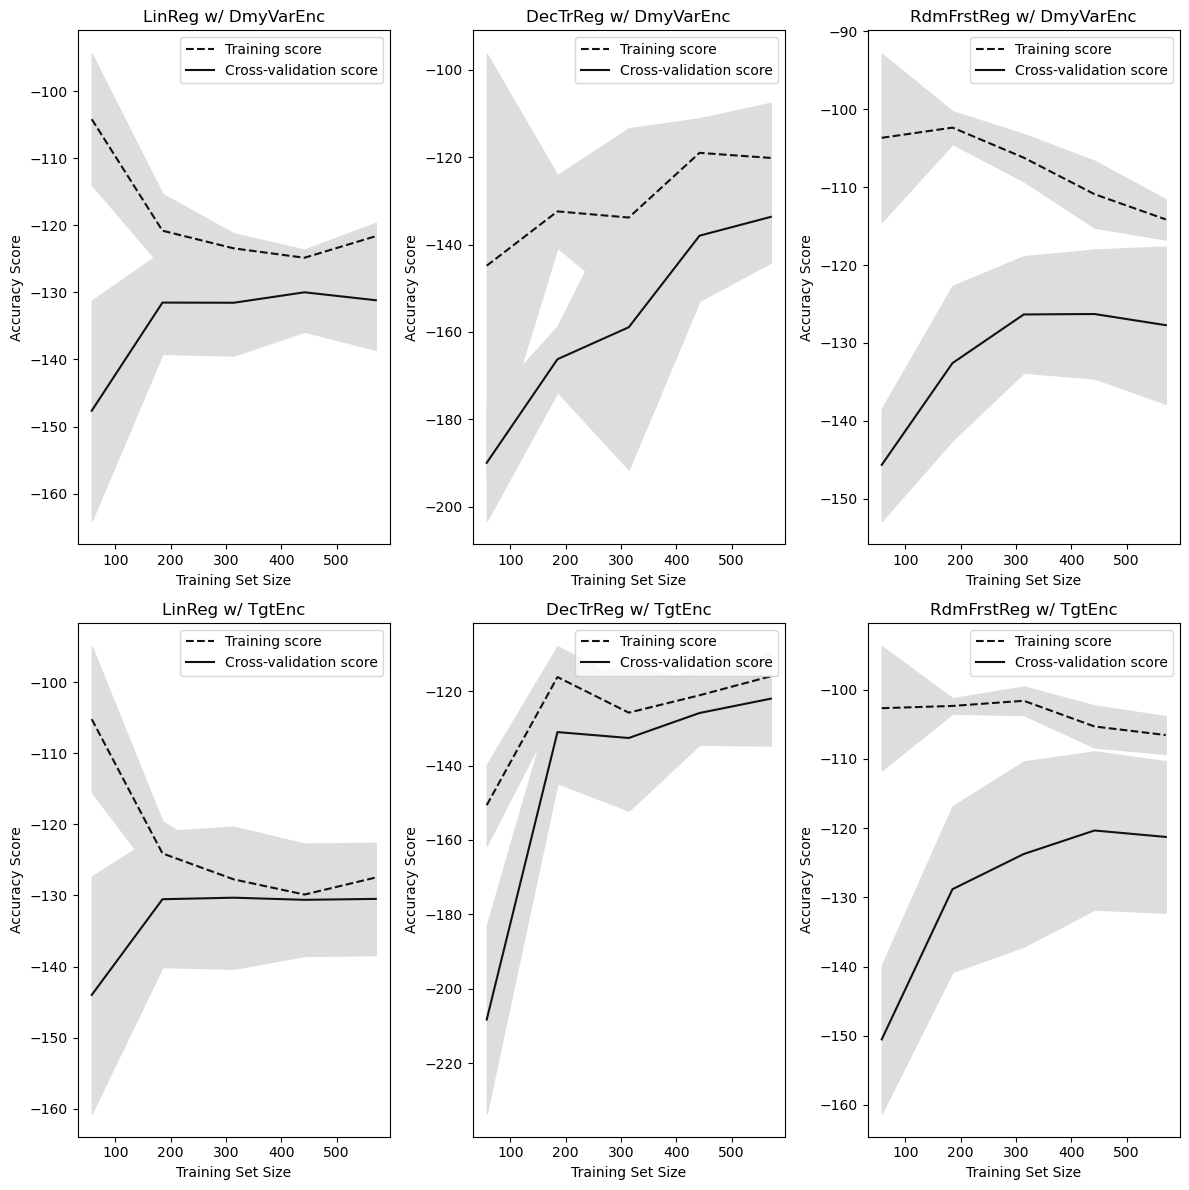

In [21]:
def get_learning_curve_analysis_outputs(model, X, y, cv = 5, full_name = None):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    if full_name is not None:
        return (train_sizes, train_scores, test_scores, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std, full_name)
    else:
        return (train_sizes, train_scores, test_scores, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std)

candidate_models = list(opt_models_enc.keys())
all_lc_scores = []
for cm in candidate_models:
    model = opt_models_enc[cm]
    model_type = model["model_type"]
    X_train = model["X_train"]
    y_train = model["y_train"]
    lc_scores = get_learning_curve_analysis_outputs(model_type, X_train, y_train, full_name = cm)
    all_lc_scores.append(lc_scores)

lc_idx = 0
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
for i in range(num_rows):
    for j in range(num_cols):
        axes[i][j].plot(all_lc_scores[lc_idx][0], all_lc_scores[lc_idx][3], '--', color="#111111",  label="Training score")
        axes[i][j].plot(all_lc_scores[lc_idx][0], all_lc_scores[lc_idx][5], color="#111111", label="Cross-validation score")
        axes[i][j].fill_between(all_lc_scores[lc_idx][0], all_lc_scores[lc_idx][3] - all_lc_scores[lc_idx][4], all_lc_scores[lc_idx][3] + all_lc_scores[lc_idx][4], color="#DDDDDD")
        axes[i][j].fill_between(all_lc_scores[lc_idx][0], all_lc_scores[lc_idx][5] - all_lc_scores[lc_idx][6], all_lc_scores[lc_idx][5] + all_lc_scores[lc_idx][6], color="#DDDDDD")
        axes[i][j].set_title(f"{all_lc_scores[lc_idx][7]}")
        axes[i][j].set_xlabel("Training Set Size"), axes[i][j].set_ylabel("Accuracy Score"), axes[i][j].legend(loc="best")
        lc_idx += 1
plt.tight_layout()
plt.show()

Now, let's go through the results:
<ol>
    <li><b>Linear Regression w/ Dummy Variable Encoding:</b> The model exhibits a somewhat high bias as indicated by the high error on the training set. There's a gap between the training and validation scores, but it's not too wide, so variance is not too high. The performance doesn't improve significantly with more data, suggesting the model might be reaching its limit.</li>
    <li><b>Decision Tree Regression w/ Dummy Variable Encoding:</b> This model has high variance as shown by the difference between training and validation scores, and also a certain level of bias as indicated by the training scores. This suggests the model is overfitting, as it performs well on the training set but poorly on the validation set. Its performance doesn't improve significantly with more data, so it's probably not a good choice.</li>
    <li><b>Random Forest Regression w/ Dummy Variable Encoding:</b> This model seems to have a reasonable balance between bias and variance. The training and validation scores are quite close, indicating that the model is not overfitting. It also appears to improve with more data, making it a good candidate.</li>
    <li><b>Linear Regression w/ Target Encoding:</b> Similar to its Dummy encoding counterpart, this model exhibits high bias but low variance. The performance doesn't improve with more data, suggesting the model might be reaching its limit.</li>
    <li><b>Decision Tree Regression w/ Target Encoding:</b> The model has high bias and high variance as shown by the gap between training and validation scores. Moreover, it doesn't significantly improve with more data. Not a good choice.</li>
    <li><b>Random Forest Regression w/ Target Encoding:</b> This model performs the best among all. It has the lowest validation scores and the gap between training and validation scores is relatively small, suggesting that it has a good bias-variance trade-off. Additionally, the model's performance appears to improve as more data is added, so it might still benefit from more training examples.</li>
</ol>
In conclusion, the Random Forest Regression with Smoothed Target Encoding is the best performing model based on the provided learning curves. It seems to have the right balance between bias and variance, and its performance improves with more data, suggesting it could still benefit from more examples. However, it's worth noting that there might be room for improvement in hyperparameter tuning or feature engineering, especially if these models are still underperforming your expectations or requirements.<br><br>

Thus we have dialed in on a model and encoding strategy that yields high quality Age predictions. Let's use the model to predict our missing age values and move on to the next data cleaning task.

In [22]:
# Transform NameTitle values in df_unknown_ages using the target encoder
df_unknown_ages["NameTitle"] = target_enc.transform(df_unknown_ages["NameTitle"])

# Make RFR training set from df_known_ages
X_train, y_train = df_known_ages.drop(columns=["Age"]), df_known_ages["Age"]

# Initialize Random Forest Regressor and fit it to X_train and y_train
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)

# Make Age predictions for df_unknown_ages and pdate df_train with the age predictions
age_predictions = RFR.predict(df_unknown_ages)
df_train.loc[df_unknown_ages.index, "Age"] = age_predictions

# Getting age predictions for the test set
df_age_prediction_test = df_test[["Age", "Pclass", "Sex", "SibSp", "Parch", "Fare_PerPassenger", "NameTitle"]].copy()
# Addressing any missing values that are contained in the Pclass, Sex, SibSp, Parch, or Fare_PerPassenger columns
df_age_prediction_test['Pclass'].fillna(round(df_age_prediction_test['Pclass'].mean()), inplace=True)
df_age_prediction_test['Sex'].fillna(df_age_prediction_test['Sex'].mode()[0], inplace=True)
df_age_prediction_test['SibSp'].fillna(round(df_age_prediction_test['SibSp'].mean()), inplace=True)
df_age_prediction_test['Parch'].fillna(round(df_age_prediction_test['Parch'].mean()), inplace=True)
df_age_prediction_test['Fare_PerPassenger'].fillna(df_age_prediction_test['Fare_PerPassenger'].mean(), inplace=True)
# Discard entries of df_age_prediction_test with known age values. The age prediction models are already
    # trained, so entries with known age values become irrelevant after addressing potential null values in
    # the step above. 
df_age_prediction_test = df_age_prediction_test[df_age_prediction_test["Age"].isnull()]
# Transform NameTitle values using the target encoder
df_age_prediction_test["NameTitle"] = target_enc.transform(df_age_prediction_test["NameTitle"])
# Drop the Age column to prepare for predictions via the trained Random Forest Regression model
df_age_prediction_test.drop("Age", axis = 1, inplace = True)
# Use the trained Random Forest Regressor to get Age predictions
age_predictions_test = RFR.predict(df_age_prediction_test)
# Update df_test with the predicted age values
df_test.loc[df_age_prediction_test.index, "Age"] = age_predictions_test

## Wrangling Cabin Feature Values

The last feature of the training set which has null values which need our attention is indeed the strangest. Let's take a look at the Cabin feature and see what we can make of it.

In [23]:
print(f"The Cabin column is missing {df_train['Cabin'].isnull().sum()} out of {len(df_train)} values," + 
      f"Thus we are missing approximately {round(100 * (df_train['Cabin'].isnull().sum()/len(df_train)),1)}% of this feature's data.")
print()
print("Let's take a look at what Cabin values look like among entries who have them...")
cabin_value_samples = list(df_train[df_train["Cabin"].notnull()]["Cabin"].values)
print(cabin_value_samples[:32])

The Cabin column is missing 687 out of 891 values,Thus we are missing approximately 77.1% of this feature's data.

Let's take a look at what Cabin values look like among entries who have them...
['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'C23 C25 C27', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'D26', 'F E69', 'D47', 'C123', 'B86', 'F2', 'C2', 'E33']


Among the entries of the training set which do contain Cabin values, we find that these values generally follow an alphanumeric pattern, consisting of an uppercase letter followed by a number. Unfortunately, this naming convention is only followed loosely. We see some cabin values containing multiple alphanumeric codes, such as passenger 28's cabin value of "C23 C25 C27". Other Cabin values are even stranger, such as passenger 76's value of "F G73", or passenger 293's value, which is simply "D".<br><br>
Let's take a closer look at the "strange" cabin values that are not simple alphanumerics. These values can easily be identified, as they are either one character long, or possess one or more empty spaces, unlike normal alphanumerics.

In [24]:
one_char_cabin_values = list(set([i for i in cabin_value_samples if len(i) == 1]))
print("The one-character long Cabin values are...")
print(one_char_cabin_values)
print()
overpacked_cabin_values = list(set([i for i in cabin_value_samples if " " in i]))
print("The overpacked Cabin values are...")
print(overpacked_cabin_values)

The one-character long Cabin values are...
['D', 'T']

The overpacked Cabin values are...
['C23 C25 C27', 'B51 B53 B55', 'F G63', 'B58 B60', 'F E69', 'F G73', 'C62 C64', 'B96 B98', 'B57 B59 B63 B66', 'B82 B84', 'D10 D12', 'C22 C26']


Interestly, the one-character-long Cabin values are only "D" or "T". Even more interestingly, all Cabin values that consist of multiple alphanumerics have numbers that increase in very small increments, and often, by increments of two. I think we've all seen this pattern before...at adjacent rooms at hotels! It is very likely that Cabin values consisting of multiple alphanumerics indicate that a passenger had multiple side-by-side rooms booked for their voyage.<br><br>

This assumption affords us an opportunity to demystify Cabin values, albeit slightly. We can add two new features to our datasets: CabinLetter and CabinNumber. We can split the alphanumerics into their constiuent components, letters and numbers. In the case of a Cabin value having multiple numbers, we can simply take the average value of these room numbers. For one-character-long Cabin values, we will set the CabinNumber to "UNSPECIFIED". For Cabin values that include different letters, we will set CabinLetter values to both letters. Furthermore, in light of these small findings about Cabin values, a picture is starting to emerge. The letters likely represent different decks of the Titanic. We can see that for Cabin values with multiple letters, the letters are always consecutive. F immediately preceds G in the alphabet, and immediately follows E. Perhaps these Cabin values indicate rooms on mezzanines or other split-level areas on the ship?<br><br>

Let's now update our datasets as specified and continue sifting through this feature.

In [25]:
def process_cabin(row):
    cabin = row['Cabin']
    # Case: Cabin is null
    if pd.isnull(cabin):
        row['CabinLetter'] = None
        row['CabinNumber'] = None
    else:
        if cabin.isalpha() and len(cabin) == 1:
            row['CabinLetter'] = cabin
            row['CabinNumber'] = None
        else:
            cabins = cabin.split(' ')
            letters = [cabin[0] for cabin in cabins]
            if len(cabins) == 1:
                row['CabinLetter'] = letters[0]
                row['CabinNumber'] = re.findall(r'\d+', cabins[0])[0] if re.findall(r'\d+', cabins[0]) else None
            else:
                if len(set(letters)) == 1:
                    row['CabinLetter'] = letters[0]
                    numbers = [int(re.findall(r'\d+', cabin)[0]) for cabin in cabins if re.findall(r'\d+', cabin)]
                    row['CabinNumber'] = round(sum(numbers) / len(numbers)) if numbers else None
                else:
                    row['CabinLetter'] = ''.join(set(letters))
                    row['CabinNumber'] = re.findall(r'\d+', ''.join(cabins))[0] if re.findall(r'\d+', ''.join(cabins)) else None
    return row

df_train["CabinLetter"] = np.nan
df_train["CabinNumber"] = np.nan
df_train = df_train.apply(process_cabin, axis=1)

df_test["CabinLetter"] = np.newaxis
df_test["CabinNumber"] = np.newaxis
df_test = df_test.apply(process_cabin, axis=1)

cl_unique_values = df_train['CabinLetter'].unique().tolist()
cn_unique_values = df_train['CabinNumber'].unique().tolist()

### Exploring the CabinLetter and CabinNumber Features

Let's now look at the of the survival rates for the various CabinLetter and CabinNumber values.

In [26]:
cabin_letter_stats = df_train.groupby("CabinLetter").agg({"Survived":["count", "mean"],
                                                          "Pclass" : "mean",
                                                          "Age" : "mean",
                                                          "SibSp" : "mean",
                                                          "Parch" : "mean",
                                                          "Fare_PerPassenger" : "mean"
                                                         })
cabin_letter_stats.columns = ['_'.join(col) for col in cabin_letter_stats.columns]
cabin_letter_stats.columns = ["Count","Mean Survived","Mean Pclass", "Mean Age", "Mean SibSp",
                              "Mean Parch", "Mean Fare Per Passenger"]
cabin_letter_stats

,Count,Mean Survived,Mean Pclass,Mean Age,Mean SibSp,Mean Parch,Mean Fare Per Passenger
CabinLetter,,,,,,,
A,15,0.466667,1.000000,47.100771,0.133333,0.133333,35.992913
B,47,0.744681,1.000000,35.259851,0.361702,0.574468,51.925857
C,59,0.593220,1.000000,37.094429,0.644068,0.474576,47.169304
D,33,0.757576,1.121212,39.162449,0.424242,0.303030,34.698109
E,32,0.750000,1.312500,37.871919,0.312500,0.312500,30.277019
EF,1,1.000000,3.000000,6.280000,1.000000,1.000000,11.179150
F,9,0.777778,2.111111,19.507061,0.666667,0.666667,11.861111
G,4,0.500000,3.000000,14.750000,0.500000,1.250000,6.790625
GF,3,0.000000,3.000000,28.666667,0.000000,0.000000,7.650000


Here are three noteworthy highlights from the above table:<br>
<ol>
    <li><b>Some decks only carry one passenger class.</b> We can see that decks A, B, C, and T only carry passengers in first class. Decks EF (formerly FE), FG, and G only carry passengers in third class.</li>
    <li><b>Small head counts for CabinLetter values.</b> We see that due to sparse data in the training set, only the decks of B, C, D, and E have large enough headcounts to be considered statistically significant. If we try to estimate the missing CabinLetter values, we will have to use these CabinLetter values as cohorts, and assign CabinLetter_Cohort values according to how well entries compare to these base CabinLetter_Cohort classes.</li>
    <li><b>Survival rate differences may or may not be statistically significant.</b> If we perform a Chi-Squared significance test on the survival rates for decks B, C, D, and E, the base CabinLetter_Cohort classes, we get a p-value of about 0.22, indicating that CabinLetters are insignificant predictors of survival; however, if we extrapolate these survival rates across the entire training set, with each cohort containing the same proportion of total membership as indicated in the table, we arrive at a p-value of far below 0.001. In order to evaluate significance, we would first need to predict the CabinLetter_Cohort for each missing value. We will return to this prediction task shortly.</li>
</ol>
Trying to predict CabinLetter_Cohort values for entries of the data with missing CabinLetter values is a frought process that invites the risk of overfitting. We will need to ensure that our predictions improve the predictive power of our dataset before modifying our data with predictions. Thus, we will approach this task using several models and use the top-performer to make our predictions.<br><br>

First, let's make note of the CabinLetter values within our data whose "headcounts" are statistically significant. The CabinLetter values B, C, D, and E have counts of 47, 59, 33, and 32, respectively. Though these counts are rather small, they are large enough to have statistical significance. Thus, we can use these CabinLetter values to form the base classes of the CabinLetter_Cohort feature. Let's take a closer look at these classes and add the CabinLetter_Cohort feature to our data.

In [27]:
cabin_letter_cohort_stats = cabin_letter_stats.loc[["B", "C", "D", "E"]]
cabin_letter_cohort_stats

,Count,Mean Survived,Mean Pclass,Mean Age,Mean SibSp,Mean Parch,Mean Fare Per Passenger
CabinLetter,,,,,,,
B,47,0.744681,1.000000,35.259851,0.361702,0.574468,51.925857
C,59,0.593220,1.000000,37.094429,0.644068,0.474576,47.169304
D,33,0.757576,1.121212,39.162449,0.424242,0.303030,34.698109
E,32,0.750000,1.312500,37.871919,0.312500,0.312500,30.277019


The entries that have non-null CabinLetter values which are not B, C, D, or E do not form groups that are large enough to be statistically significant. Thus, we will add a new feature, CabinLetter_Cohort, to our datasets. If an entry has a CabinLetter of B, C, D, or E, its CabinLetter value will be assigned as its CabinLetter_Cohort value. If an entry has a "minority" CabinLetter value, it will be assigned a CabinLetter_Cohort value determined by a mapping of its CabinLetter to the most similar CabinLetter_Cohort (B, C, D, or E) using the Euclidean distance between it and the mean values of the four cohorts.<br><br>

Entries that are missing CabinLetter values entirely will be dealt with next.

In [28]:
scaler = MinMaxScaler()

df_map_cabin_letter_cohorts = df_train.copy()
df_map_cabin_letter_cohorts['CabinLetter_Cohort'] = df_map_cabin_letter_cohorts['CabinLetter']

df_map_cabin_letter_cohorts_test = df_test.copy()
df_map_cabin_letter_cohorts_test['CabinLetter_Cohort'] = df_map_cabin_letter_cohorts_test['CabinLetter']

# Normalize the data
for column in ['Pclass', 'Age', 'Fare_PerPassenger', 'NumFamily']:
    df_map_cabin_letter_cohorts[column] = scaler.fit_transform(df_map_cabin_letter_cohorts[[column]])
    df_map_cabin_letter_cohorts_test[column] = scaler.transform(df_map_cabin_letter_cohorts_test[[column]])

mean_values = df_map_cabin_letter_cohorts[df_map_cabin_letter_cohorts['CabinLetter'].isin(
    ['B', 'C', 'D', 'E'])].groupby('CabinLetter')[['Pclass', 'Age', 'Fare_PerPassenger', 'NumFamily']].mean()

minority_groups = df_map_cabin_letter_cohorts[~df_map_cabin_letter_cohorts['CabinLetter'].isin(
    ['B', 'C', 'D', 'E', np.nan])]['CabinLetter'].unique()

minority_groups_test = df_map_cabin_letter_cohorts_test[~df_map_cabin_letter_cohorts_test['CabinLetter'].isin(
    ['B', 'C', 'D', 'E', np.nan])]['CabinLetter'].unique()

for df in [df_map_cabin_letter_cohorts, df_map_cabin_letter_cohorts_test]:
    for group in minority_groups:
        minority_data = df[df['CabinLetter'] == group][
            ['Pclass', 'Age', 'Fare_PerPassenger', 'NumFamily']].mean()
        if minority_data.isnull().any():
            continue
        min_distance = np.inf
        closest_group = None
        for major_group in ['B', 'C', 'D', 'E']:
            major_data = mean_values.loc[major_group]
            if major_data.isnull().any():
                continue
            dist = distance.euclidean(minority_data, major_data)
            if dist < min_distance:
                min_distance = dist
                closest_group = major_group
        df.loc[df['CabinLetter'] == group, 'CabinLetter_Cohort'] = closest_group
        

df_train["CabinLetter_Cohort"] = df_map_cabin_letter_cohorts["CabinLetter_Cohort"]
df_test["CabinLetter_Cohort"] = df_map_cabin_letter_cohorts_test["CabinLetter_Cohort"]

In [29]:
cohort_mapping = {'B': '1', 'C': '2', 'D': '3', 'E': '4'}

df_train['CabinLetter_Cohort'] = df_train['CabinLetter'].map(cohort_mapping)
df_train.loc[~df_train['CabinLetter'].isin(['B', 'C', 'D', 'E']), 'CabinLetter_Cohort'] = None

df_test['CabinLetter_Cohort'] = df_test['CabinLetter'].map(cohort_mapping)
df_test.loc[~df_test['CabinLetter'].isin(['B', 'C', 'D', 'E']), 'CabinLetter_Cohort'] = None

### Predicting Missing CabinLetter_Cohort Values

#### Four Candidate Classification Models

Since the CabinLetter_Cohort feature is categorical, coming up with predictions for missing values is a classification task. We have four candidate models for this task. They are as follows:
<ol>
    <li><b>Gradient Boosting Classifier:</b> An ensemble model of decision tree classifiers. Iteratively, it applies a decision tree classifier to the dataset, and computes the residual values (alternatively, negative gradients with respect to its loss function) between its predictions and the target values. Then a new model is fit to the residuals, where it aims to predict the error of the previous model. The overall predictions are then updated accordingly. After a number of iterations through this process, a final classification model is created from a weighted sum of the intermittent models.</li>
    <li><b>Decision Tree Classifier:</b> A simplified version of the above approach. This classifier operates in a similar fashion to the Decision Tree Regressor employed earlier in this project.</li>
    <li><b>Random Forest Classifier:</b> An ensemble of Decision Tree Classifiers initialized with random ordering of branches. It functions in a very similar manner to the Random Forest Regressor employed earlier.</li>
    <li><b>Ensemble Classifier (with soft voting):</b> This classifier is a combination of the three previous models. It trains each of them, and then combines the probabilities that each predicts into a weighted sum of probabilities for each class.</li>
</ol>
In order to improve computational efficiency for hyperparameter tuning, and since the SibSp and Parch features both indicative of the family structure of passengers aboard the ship, we will consider them as a sum with a new feature called NumFamily.

In [30]:
df_clc = df_train[df_train["CabinLetter_Cohort"].notnull()].copy()
features = ['Pclass', 'Age', 'Fare_PerPassenger', 'NumFamily']

X = df_clc[features]
y = df_clc["CabinLetter_Cohort"]

DTC = ("DecTrClsfr", DecisionTreeClassifier(), X, y,
      {
          "max_depth" : [5],
          "max_features" : [None],
          "min_samples_leaf" : [1],
          "min_samples_split" : [4]
      })

RFC = ("RdmFrstClsfr", RandomForestClassifier(), X, y,
       {
           "bootstrap" : [True],
           "max_depth" : [None],
           "max_features" : ["sqrt"],
           "min_samples_leaf" : [5],
           "min_samples_split" : [14],
           "n_estimators" : [200]
      })

GBC = ("GradBstgClsfr", GradientBoostingClassifier(), X, y,
       {
           "learning_rate" : [0.01],
           "max_depth" : [5],
           "max_features" : [None],
           "min_samples_leaf" : [1],
           "min_samples_split" : [4],
           "n_estimators" : [50],
           "subsample" : [1.0]
       })

model_tuning_list = [DTC, RFC, GBC]

# Uncomment to Run Hyperparameter Tuning for Models
trial_number = 5
trial_results = tune_hyperparameters(model_tuning_list, trial_number, cv = 5)
# save_tuning_log(trial_results, "CabinLetter_Cohort_Prediction")

# Uncomment to consolidate trials into single file
# centralize_tuning_logs(1, trial_number, "CabinLetter_Cohort_Prediction", move_to = "Old Tuning Logs")

with open("Hyperparameter_Tuning_for_CabinLetter_Cohort_Prediction_All_Trials.txt", "r") as f:
    print(f.read())

Trial 5 started at 2023-06-25 19:24:27.468177
________________________________________________________________________________
Finding Hyperparameters for DecTrClsfr. Hyperparameter search space is...
* max_depth: [5]
* max_features: [None]
* min_samples_leaf: [1]
* min_samples_split: [4]

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best hyperparameters for DecTrClsfr...
* max_depth: 5
* max_features: None
* min_samples_leaf: 1
* min_samples_split: 4

Hyperparameter Tuning for DecTrClsfr took 6.7 seconds.
________________________________________________________________________________
Finding Hyperparameters for RdmFrstClsfr. Hyperparameter search space is...
* bootstrap: [True]
* max_depth: [None]
* max_features: ['sqrt']
* min_samples_leaf: [5]
* min_samples_split: [14]
* n_estimators: [200]

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best hyperparameters for RdmFrstClsfr...
* bootstrap: True
* max_depth: None
* max_features: sqrt
* min_samples_leaf: 

Since training data is especially scarce for this task, we will use K-Fold Cross-Validation to evaluate our models. This method splits data into training sets and validation sets multiple times, such that all partitions of the data serve as a validation set for a single pass. Means of specified performance scores are then computed. In this task, we will focus on four performance scores to assess the candidate models' predictive capacities:
<ol>
    <li><b>Accuracy:</b> Simply the number of correct predictions divided by the total number of predictions made.</li>
    <li><b>Precision:</b> The number of correct predictions for a given class divided by the total number of predictions for that class. In short, a metric to measure the rate of false positives.</li>
    <li><b>Recall:</b> The number of correct predictions for a given class divided by the actual number belonging to that class. In short, a metric to measure the rate of false negatives.</li>
    <li><b>F1:</b> The harmonic mean of Precision and Recall. A balancing score that takes both the false positive and false negative rates into account.</li>
</ol>
To assess our models' tendancies to overfit the scarce training data, we will also acquire the variances for each of these scores across each of the K folds. Low variances indicate that a given model is capable of generalizing its learning. The model that performs best overall between its performance scores and their variances will be considered the top-performer and will be used to predict missing CabinLetter_Cohort values.

Scores for Gradient Boosting Classifier:
    * Mean Accuracy: 0.49156; Accuracy Variance: 0.00168
    * Mean Precision: 0.58644; Precision Variance: 0.00116
    * Mean Recall: 0.49156; Recall Variance: 0.00168
    * Mean F1 Score: 0.48441; F1 Score Variance: 0.00301
    * Overall performance score (higher is better): 2.05396
    * Overall fitness score (lower is better): 0.00753

Scores for Decision Tree Classifier:
    * Mean Accuracy: 0.60825; Accuracy Variance: 0.00572
    * Mean Precision: 0.64146; Precision Variance: 0.0059
    * Mean Recall: 0.60825; Recall Variance: 0.00572
    * Mean F1 Score: 0.6037; F1 Score Variance: 0.00589
    * Overall performance score (higher is better): 2.46166
    * Overall fitness score (lower is better): 0.02322

Scores for Random Forest Classifier:
    * Mean Accuracy: 0.41528; Accuracy Variance: 0.00285
    * Mean Precision: 0.48572; Precision Variance: 0.00928
    * Mean Recall: 0.41528; Recall Variance: 0.00285
    * Mean F1 Score: 0.41075; F1 S

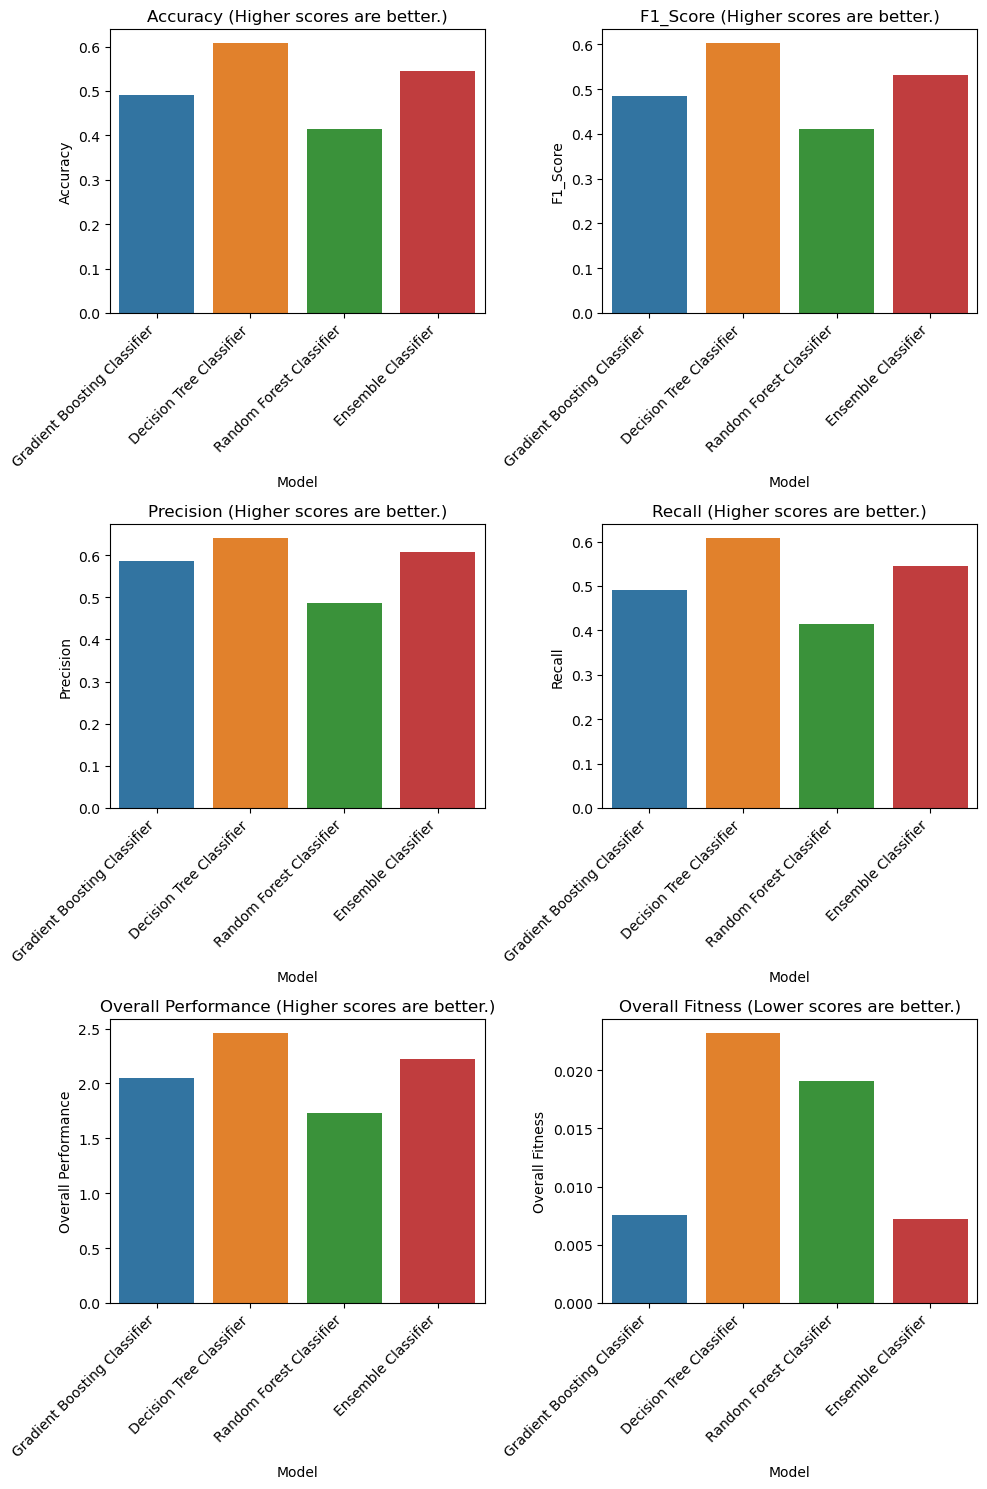

In [31]:
def perform_kfold_cv(classifier, df, features, target, k=4):
    kf = KFold(n_splits=k)
    accuracy_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    for train_index, test_index in kf.split(df):
        X_train, X_test = df.iloc[train_index][features], df.iloc[test_index][features]
        y_train, y_test = df.iloc[train_index][target], df.iloc[test_index][target]
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy_score_val = accuracy_score(y_test, y_pred)
        f1_score_val = f1_score(y_test, y_pred, average='weighted')
        precision_score_val = precision_score(y_test, y_pred, average='weighted')
        recall_score_val = recall_score(y_test, y_pred, average='weighted')
        accuracy_scores.append(accuracy_score_val)
        f1_scores.append(f1_score_val)
        precision_scores.append(precision_score_val)
        recall_scores.append(recall_score_val)
    return np.mean(accuracy_scores), np.mean(f1_scores), np.mean(precision_scores), np.mean(recall_scores), accuracy_scores, f1_scores, precision_scores, recall_scores

def visualize_model_performance(models_performance):
    metrics = ['Accuracy', 'F1_Score', 'Precision', 'Recall', "Overall Performance", "Overall Fitness"]  
    fig, axs = plt.subplots(3, 2, figsize=(10,15))
    for i, metric in enumerate(metrics):
        ax = axs[i//2, i%2]
        sns.barplot(x='Model', y=metric, data=models_performance, ax=ax)
        if metric != "Overall Fitness":
            ax.set_title(f'{metric} (Higher scores are better.)')
        else:
            ax.set_title(f'{metric} (Lower scores are better.)')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()
    plt.show()

gbc = GradientBoostingClassifier(random_state=0,
                                 learning_rate = trial_results["GradBstgClsfr"]["Best Hyperparameters"]["learning_rate"],
                                 max_depth = trial_results["GradBstgClsfr"]["Best Hyperparameters"]["max_depth"],
                                 max_features = trial_results["GradBstgClsfr"]["Best Hyperparameters"]["max_features"],
                                 min_samples_leaf = trial_results["GradBstgClsfr"]["Best Hyperparameters"]["min_samples_leaf"],
                                 min_samples_split = trial_results["GradBstgClsfr"]["Best Hyperparameters"]["min_samples_split"],
                                 n_estimators = trial_results["GradBstgClsfr"]["Best Hyperparameters"]["n_estimators"],
                                 subsample = trial_results["GradBstgClsfr"]["Best Hyperparameters"]["subsample"])
dt = DecisionTreeClassifier(max_depth = trial_results["DecTrClsfr"]["Best Hyperparameters"]["max_depth"],
                            max_features = trial_results["DecTrClsfr"]["Best Hyperparameters"]["max_features"],
                            min_samples_leaf = trial_results["DecTrClsfr"]["Best Hyperparameters"]["min_samples_leaf"],
                            min_samples_split = trial_results["DecTrClsfr"]["Best Hyperparameters"]["min_samples_split"])
rf = RandomForestClassifier(random_state = 0,
                            bootstrap = trial_results["RdmFrstClsfr"]["Best Hyperparameters"]["bootstrap"],
                            max_depth = trial_results["RdmFrstClsfr"]["Best Hyperparameters"]["max_depth"],
                            max_features = trial_results["RdmFrstClsfr"]["Best Hyperparameters"]["max_features"],
                            min_samples_leaf = trial_results["RdmFrstClsfr"]["Best Hyperparameters"]["min_samples_leaf"],
                            min_samples_split = trial_results["RdmFrstClsfr"]["Best Hyperparameters"]["min_samples_split"],
                            n_estimators = trial_results["RdmFrstClsfr"]["Best Hyperparameters"]["n_estimators"])
eclf = VotingClassifier(estimators=[
    ("gbc", gbc),
    ('dt', dt), 
    ('rf', rf)
], voting='soft')

classifiers = [(gbc,"Gradient Boosting Classifier"),(dt,"Decision Tree Classifier"),
               (rf,"Random Forest Classifier"),(eclf,"Ensemble Classifier")]

models_performance = pd.DataFrame()

for classifier in classifiers:
    clsfr = classifier[0]
    c_name = classifier[1]
    mean_accuracy, mean_f1_score, mean_precision, mean_recall, accuracy_scores, f1_scores, precision_scores, recall_scores = perform_kfold_cv(clsfr, df_clc, features, "CabinLetter_Cohort")
    performance_score = mean_accuracy + mean_f1_score + mean_precision + mean_recall
    overfitting_score = np.var(accuracy_scores) + np.var(f1_scores) + np.var(precision_scores) + np.var(recall_scores)
    new_row = pd.DataFrame({'Model': [c_name], 'Accuracy': [mean_accuracy], 'Precision': [mean_precision],
                            'Recall': [mean_recall], 'F1_Score': [mean_f1_score], "Overall Performance" : performance_score,
                           "Overall Fitness" : overfitting_score})    
    models_performance = pd.concat([models_performance, new_row], ignore_index=True)
    print(f"Scores for {c_name}:")
    r5 = lambda x: round(x, 5)
    print(f"    * Mean Accuracy: {r5(mean_accuracy)}; Accuracy Variance: {r5(np.var(accuracy_scores))}")
    print(f"    * Mean Precision: {r5(mean_precision)}; Precision Variance: {r5(np.var(precision_scores))}")
    print(f"    * Mean Recall: {r5(mean_recall)}; Recall Variance: {r5(np.var(recall_scores))}")
    print(f"    * Mean F1 Score: {r5(mean_f1_score)}; F1 Score Variance: {r5(np.var(f1_scores))}")
    print(f"    * Overall performance score (higher is better): {r5(performance_score)}")
    print(f"    * Overall fitness score (lower is better): {r5(overfitting_score)}")
    print()

visualize_model_performance(models_performance)

Let's take a look at the results for these candidate models:
<ul>
    <li><b>The Gradient Boosting Classifier</b> shows moderate performance across all metrics with an overall performance score of 2.03388. Its fitness score, which is the sum of all score variances, is 0.00983. The fitness score indicates how much the model's performance varies, and lower values are generally desirable as they signify more consistent performance.</li>
    <li><b>The Decision Tree Classifier</b> has the highest performance score among all models (2.47774), suggesting it has the highest average performance across accuracy, precision, recall, and F1 score. However, it also has the highest fitness score (0.02759), indicating that its performance is less consistent than the other models. This model might overfit the data and perform poorly with new data, despite showing good results in cross-validation.</li>
    <li><b>The Random Forest Classifier</b> has the lowest overall performance score (1.68182) among all models. Although its fitness score (0.01535) is lower than the Decision Tree's, indicating slightly more consistent performance, it is still higher than the Gradient Boosting and Ensemble Classifiers, and its performance is generally worse.</li>
    <li><b>The Ensemble Classifier</b> has a relatively high overall performance score (2.24035), second only to the Decision Tree Classifier. Importantly, it also has the second-lowest fitness score (0.01155), suggesting its performance is relatively consistent.</li>
</ul>
Based on these findings, the <b>Gradient Boosting Classifier</b> offers poor consistancy and the <b>Random Forest Classifier</b> offers poor performance. The <b>Ensemble Classifier</b> seems to offer a good balance between performance and consistency. It does not reach the highest performance of the <b>Decision Tree Classifier</b>, but it is significantly more consistent, which will likely make it more reliable when deployed on new data. The <b>Decision Tree Classifier</b> has the best performance for each score, though may not perform as reliably as the <b>Ensemble Classifier</b> as demonstrated by its fitness score which is nearly double that of the other models.<br><br>

Since both the <b>Ensemble</b> and <b>Decision Tree</b> models best each other in performance and fitness, we will make CabinLetter_Cohort classifications using both models, and compare the performance of the predictions in predicting survivorship in the next task.

In [32]:
df_train_known_clc = df_train[df_train["CabinLetter_Cohort"].notnull()].copy()
df_train_unknown_clc = df_train[df_train["CabinLetter_Cohort"].isnull()].copy()

X_train = df_train_known_clc[features]
y_train = df_train_known_clc["CabinLetter_Cohort"]

dt.fit(X_train, y_train)
eclf.fit(X_train, y_train)

X_test = df_train_unknown_clc[features]
dt_predictions = dt.predict(X_test)
eclf_predictions = eclf.predict(X_test)

df_train["CabinLetter_Cohort_DT"] = df_train["CabinLetter_Cohort"]
df_train["CabinLetter_Cohort_ECLF"] = df_train["CabinLetter_Cohort"]

df_train.loc[df_train_unknown_clc.index, "CabinLetter_Cohort_DT"] = dt_predictions
df_train.loc[df_train_unknown_clc.index, "CabinLetter_Cohort_ECLF"] = eclf_predictions

df_test_unknown_clc = df_test[df_test["CabinLetter_Cohort"].isnull()].copy()
df_test_unknown_clc["Pclass"].fillna(round(df_test["Pclass"].mean()), inplace = True)
df_test_unknown_clc["SibSp"].fillna(round(df_test["SibSp"].mean()), inplace = True)
df_test_unknown_clc["Parch"].fillna(round(df_test["Parch"].mean()), inplace = True)
df_test_unknown_clc["Fare_PerPassenger"].fillna(df_test["Fare_PerPassenger"].mean(), inplace = True)

X_test_test = df_test_unknown_clc[features]
dt_predictions = dt.predict(X_test_test)
eclf_predictions = eclf.predict(X_test_test)

df_test["CabinLetter_Cohort_DT"] = df_test["CabinLetter_Cohort"]
df_test["CabinLetter_Cohort_ECLF"] = df_test["CabinLetter_Cohort"]

df_test.loc[df_test_unknown_clc.index, "CabinLetter_Cohort_DT"] = dt_predictions
df_test.loc[df_test_unknown_clc.index, "CabinLetter_Cohort_ECLF"] = eclf_predictions

### Analysis of CabinNumber Values

#### Survival Rate by CabinNumber

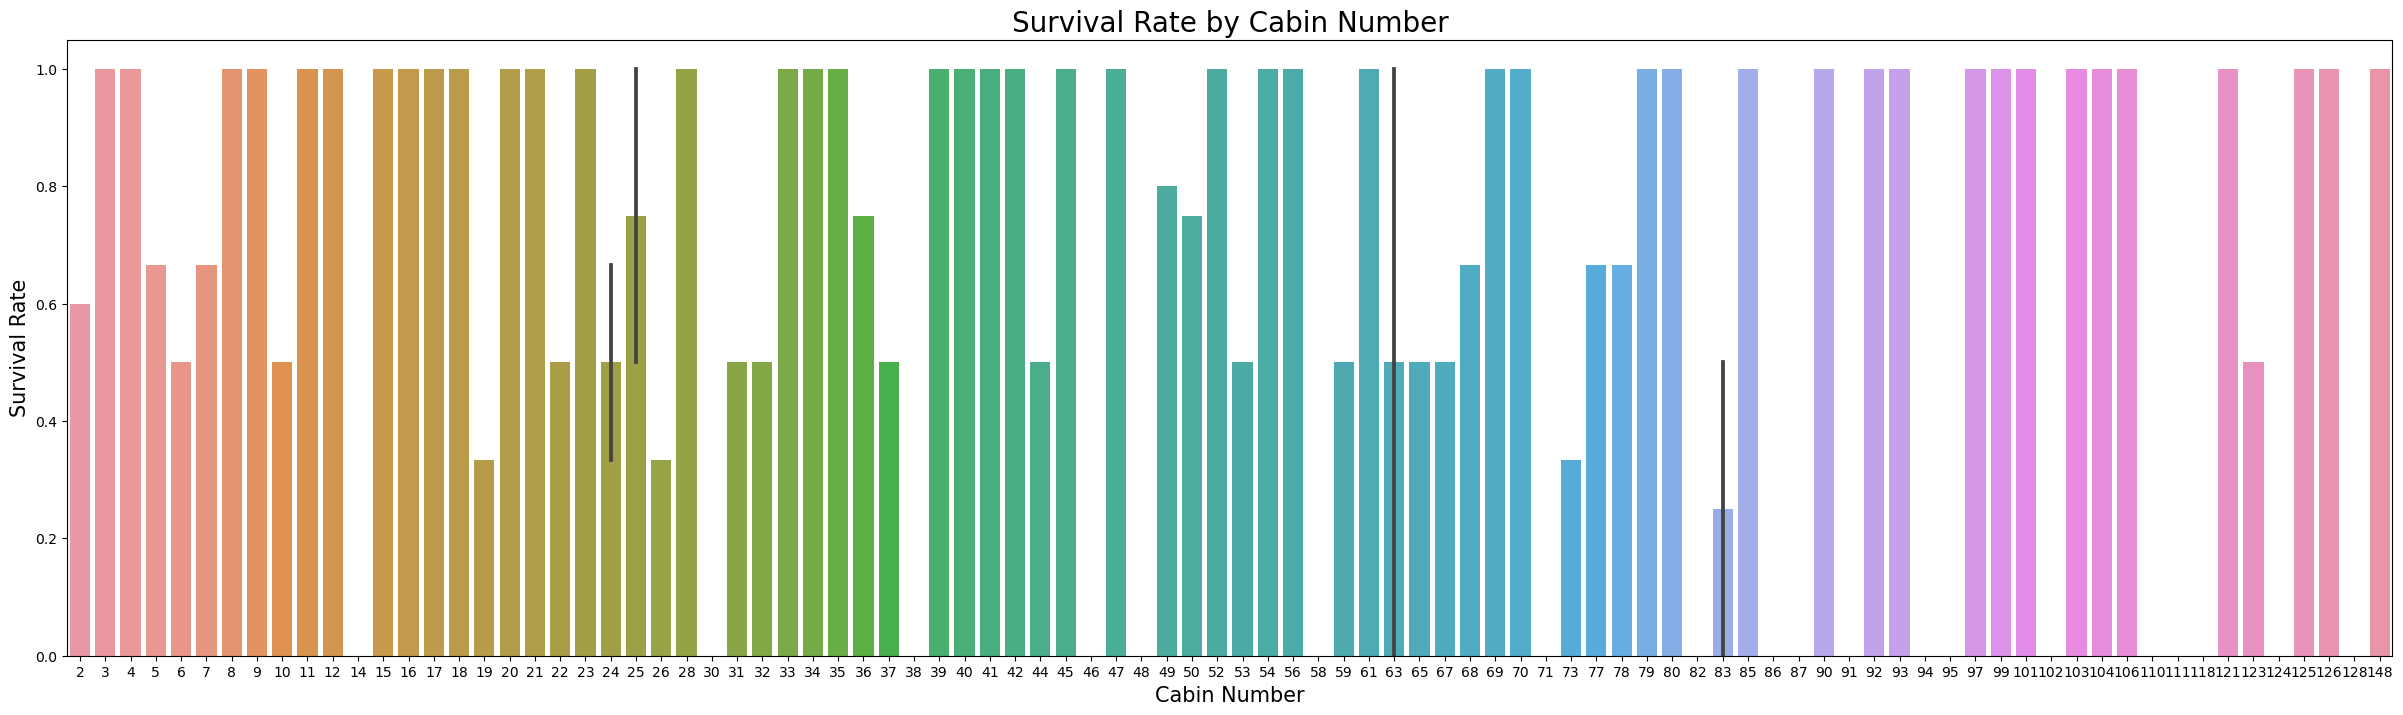

In [33]:
cabin_df = df_train[df_train['CabinNumber'].notna()].copy().groupby('CabinNumber')['Survived'].mean().reset_index()
cabin_df["CabinNumber"] = cabin_df["CabinNumber"].astype(int)

plt.figure(figsize=(30,8))
sns.barplot(x='CabinNumber', y='Survived', data=cabin_df)
plt.xlabel('Cabin Number', fontsize = 15)
plt.ylabel('Survival Rate', fontsize = 15)
plt.title('Survival Rate by Cabin Number', fontsize = 20)
plt.show()

If we look at the mean survival rate for each CabinNumber value, no apparent pattern emerges. This is likely due to the scarcity of CabinNumber data. Let's try again after grouping entries into bins according to their quantiles.

In [34]:
def assign_CabinNumber_Group(cn_val, boundaries):
    boundary_dict = {}
    for b in boundaries:
        v = round(b[0],3)
        for i in range(b[1][0], b[1][1] + 1):
            boundary_dict[i] = v
    return(boundary_dict[cn_val])

cabin_df = df_train[df_train['CabinNumber'].notna()].copy()
cabin_df["CabinNumber"] = cabin_df["CabinNumber"].astype(int)
data = cabin_df["CabinNumber"].values
bins = 6
cng_boundaries = []
q_lo = 0
for qval in  [i/bins for i in range(1, bins + 1)]:
    q_hi = round(np.quantile(data, qval))
    print(f"Quantile {round(qval,3)}: Lowest Room Number: {q_lo}; Highest Room Number: {q_hi}")
    boundaries = (qval, (q_lo, q_hi))
    cng_boundaries.append(boundaries)
    q_lo = q_hi + 1

Quantile 0.167: Lowest Room Number: 0; Highest Room Number: 17
Quantile 0.333: Lowest Room Number: 18; Highest Room Number: 29
Quantile 0.5: Lowest Room Number: 30; Highest Room Number: 43
Quantile 0.667: Lowest Room Number: 44; Highest Room Number: 64
Quantile 0.833: Lowest Room Number: 65; Highest Room Number: 92
Quantile 1.0: Lowest Room Number: 93; Highest Room Number: 148


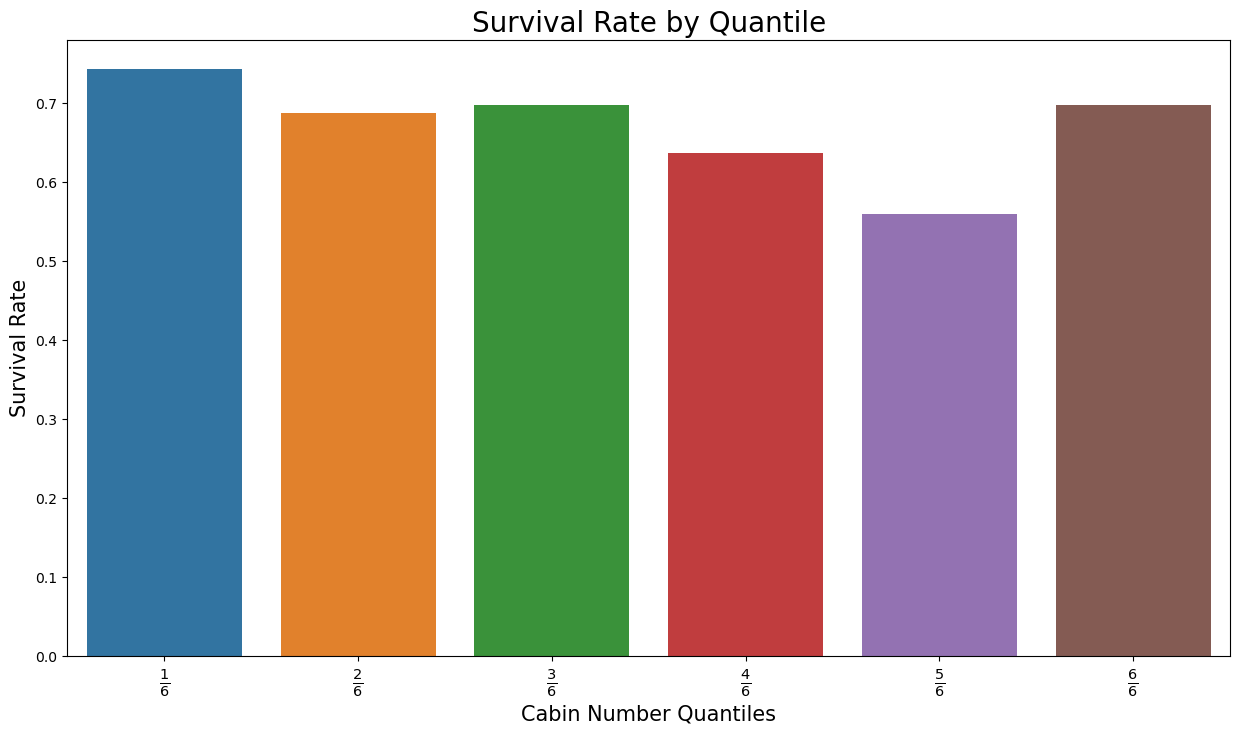

,Headcount,Survival Rate
CabinNumber_Group,,
0.167,35,0.742857
0.333,32,0.687500
0.500,33,0.696970
0.667,33,0.636364
0.833,34,0.558824
1.000,33,0.696970


In [35]:
cabin_df["CabinNumber_Group"] = cabin_df["CabinNumber"].apply(lambda x: assign_CabinNumber_Group(x, cng_boundaries))

cabin_df_plot = cabin_df.groupby('CabinNumber_Group')['Survived'].mean().reset_index()

plt.figure(figsize=(15,8))
sns.barplot(x='CabinNumber_Group', y='Survived', data=cabin_df_plot)
labels = [r'$\frac{1}{6}$', r'$\frac{2}{6}$', r'$\frac{3}{6}$', r'$\frac{4}{6}$', r'$\frac{5}{6}$', r'$\frac{6}{6}$']
plt.xlabel('Cabin Number Quantiles', fontsize=15)
plt.xticks(range(len(labels)), labels, fontsize = 15)
plt.ylabel('Survival Rate', fontsize = 15)
plt.title('Survival Rate by Quantile', fontsize = 20)
plt.show()

cabin_number_groups_stats = cabin_df.groupby("CabinNumber_Group").agg({"Survived" : ["count", "mean"]})
cabin_number_groups_stats.columns = ['_'.join(col) for col in cabin_number_groups_stats.columns]
cabin_number_groups_stats.columns = ["Headcount", "Survival Rate"]
cabin_number_groups_stats

Recognizing that CabinNumber_Group is ordinal, we see that there is a slight U-shaped relationship between survival rate and CabinNumber, with values in the $\frac{1}{6}$ and $\frac{6}{6}$ quantiles having higher survival rates than those of the intermediate quantiles. Since we detected a relationship between CabinNumber and Survival, let's add a CabinNumber_Group feature to our data.

In [36]:
df_train_cabin_number_groups = df_train[df_train["CabinNumber"].notnull()].copy()
df_train_cabin_number_groups["CabinNumber_Group"] = df_train_cabin_number_groups["CabinNumber"].apply(
    lambda x: assign_CabinNumber_Group(int(x), cng_boundaries))
df_train.loc[df_train_cabin_number_groups.index, "CabinNumber_Group"] = df_train_cabin_number_groups["CabinNumber_Group"]

df_test_cabin_number_groups = df_test[df_test["CabinNumber"].notnull()].copy()
df_test_cabin_number_groups["CabinNumber_Group"] = df_test_cabin_number_groups["CabinNumber"].apply(
    lambda x: assign_CabinNumber_Group(int(x), cng_boundaries))
df_test.loc[df_test_cabin_number_groups.index, "CabinNumber_Group"] = df_test_cabin_number_groups["CabinNumber_Group"]

### Imputing CabinNumber_Group Classifications: Four Candidate Models

Since this classification task is highly similar to the one performed for the CabinLetter_Cohort feature, we will compare the same four models. Additionally, since we will be using the same features for this classification task, hyperparameter tuning is unnecessary.

Scores for Gradient Boosting Classifier:
    * Mean Accuracy: 0.255; Accuracy Variance: 0.00547
    * Mean Precision: 0.29065; Precision Variance: 0.00868
    * Mean Recall: 0.255; Recall Variance: 0.00547
    * Mean F1 Score: 0.25083; F1 Score Variance: 0.00621
    * Overall performance score (higher is better): 1.05148
    * Overall fitness score (lower is better): 0.02584

Scores for Decision Tree Classifier:
    * Mean Accuracy: 0.21; Accuracy Variance: 0.0029
    * Mean Precision: 0.3038; Precision Variance: 0.01613
    * Mean Recall: 0.21; Recall Variance: 0.0029
    * Mean F1 Score: 0.20566; F1 Score Variance: 0.00468
    * Overall performance score (higher is better): 0.92946
    * Overall fitness score (lower is better): 0.0266



C:\Users\Cevan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cevan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Scores for Random Forest Classifier:
    * Mean Accuracy: 0.26; Accuracy Variance: 0.0022
    * Mean Precision: 0.30624; Precision Variance: 0.00489
    * Mean Recall: 0.26; Recall Variance: 0.0022
    * Mean F1 Score: 0.24509; F1 Score Variance: 0.00094
    * Overall performance score (higher is better): 1.07133
    * Overall fitness score (lower is better): 0.01023

Scores for Ensemble Classifier:
    * Mean Accuracy: 0.265; Accuracy Variance: 0.00208
    * Mean Precision: 0.33868; Precision Variance: 0.00079
    * Mean Recall: 0.265; Recall Variance: 0.00208
    * Mean F1 Score: 0.25891; F1 Score Variance: 0.0005
    * Overall performance score (higher is better): 1.12759
    * Overall fitness score (lower is better): 0.00545



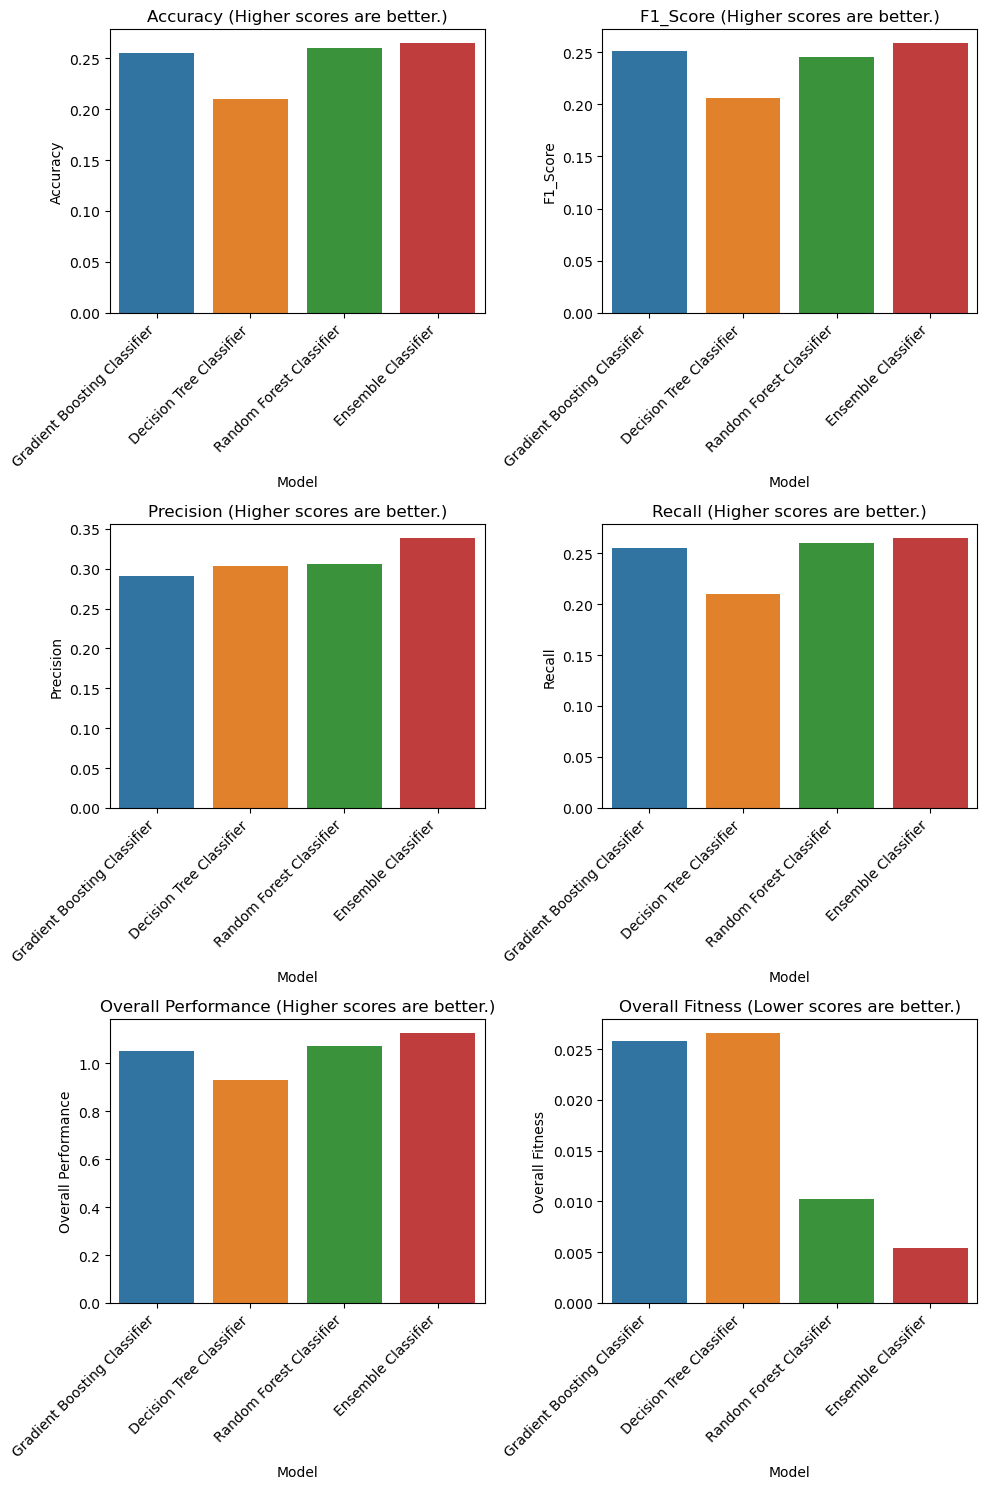

In [37]:
df_cng = df_train[df_train['CabinNumber_Group'].notna()].copy()
df_cng["CabinNumber_Group"] = df_cng["CabinNumber_Group"].astype(str)
features = ['Pclass', "Age", 'Fare_PerPassenger', 'NumFamily']

classifiers = [(gbc,"Gradient Boosting Classifier"),(dt,"Decision Tree Classifier"),
               (rf,"Random Forest Classifier"),(eclf,"Ensemble Classifier")]

models_performance = pd.DataFrame()

for classifier in classifiers:
    clsfr = classifier[0]
    c_name = classifier[1]
    mean_accuracy, mean_f1_score, mean_precision, mean_recall, accuracy_scores, f1_scores, precision_scores, recall_scores = perform_kfold_cv(clsfr, df_cng, features, "CabinNumber_Group")
    performance_score = mean_accuracy + mean_f1_score + mean_precision + mean_recall
    overfitting_score = np.var(accuracy_scores) + np.var(f1_scores) + np.var(precision_scores) + np.var(recall_scores)
    new_row = pd.DataFrame({'Model': [c_name], 'Accuracy': [mean_accuracy], 'Precision': [mean_precision],
                            'Recall': [mean_recall], 'F1_Score': [mean_f1_score], "Overall Performance" : performance_score,
                           "Overall Fitness" : overfitting_score})    
    models_performance = pd.concat([models_performance, new_row], ignore_index=True)
    print(f"Scores for {c_name}:")
    r5 = lambda x: round(x, 5)
    print(f"    * Mean Accuracy: {r5(mean_accuracy)}; Accuracy Variance: {r5(np.var(accuracy_scores))}")
    print(f"    * Mean Precision: {r5(mean_precision)}; Precision Variance: {r5(np.var(precision_scores))}")
    print(f"    * Mean Recall: {r5(mean_recall)}; Recall Variance: {r5(np.var(recall_scores))}")
    print(f"    * Mean F1 Score: {r5(mean_f1_score)}; F1 Score Variance: {r5(np.var(f1_scores))}")
    print(f"    * Overall performance score (higher is better): {r5(performance_score)}")
    print(f"    * Overall fitness score (lower is better): {r5(overfitting_score)}")
    print()

visualize_model_performance(models_performance)

Unfortunately, the results for this classification task were far less promising than for making CabinLetter_Cohort predictions. The <b>Ensemble</b> model, despite having the best accuracy score among the four models, could not make accurate predictions above 30%. Furthermore, as shown by the zero-division warning, the <b>Decision Tree</b> model did not even make predictions for one or more of the CabinNumber_Group classes. Since these results are of low quality, it would not be wise to update missing CabinNumber_Group values with any of these models. Therefore, missing CabinNumber_Group values in the training and test sets will be left as null values.

# Conclusion

We have finally arrived upon a fully wrangled dataset. Let's take a look at the cleaned dataset!

In [38]:
df_train.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Fare_PerPassenger,NameTitle,NumFamily,CompleteInfo,CabinLetter,CabinNumber,CabinLetter_Cohort,CabinLetter_Cohort_DT,CabinLetter_Cohort_ECLF,CabinNumber_Group
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.00,1,0,A/5 21171,7.2500,NaN,...,7.25000,Mr,1,0,None,None,None,4,4,NaN
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.00,1,0,PC 17599,71.2833,C85,...,71.28330,Mrs,1,1,C,85,2,2,2,0.833
3,1,3,"Heikkinen, Miss. Laina",1,26.00,0,0,STON/O2. 3101282,7.9250,NaN,...,7.92500,Miss,0,0,None,None,None,4,4,NaN
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.00,1,0,113803,53.1000,C123,...,26.55000,Mrs,1,1,C,123,2,2,2,1.000
5,0,3,"Allen, Mr. William Henry",0,35.00,0,0,373450,8.0500,NaN,...,8.05000,Mr,0,0,None,None,None,4,4,NaN
6,0,3,"Moran, Mr. James",0,24.07,0,0,330877,8.4583,NaN,...,8.45830,Mr,0,0,None,None,None,4,4,NaN
7,0,1,"McCarthy, Mr. Timothy J",0,54.00,0,0,17463,51.8625,E46,...,51.86250,Mr,0,1,E,46,4,4,4,0.667
8,0,3,"Palsson, Master. Gosta Leonard",0,2.00,3,1,349909,21.0750,NaN,...,5.26875,Master,4,0,None,None,None,4,4,NaN
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.00,0,2,347742,11.1333,NaN,...,3.71110,Mrs,2,0,None,None,None,4,4,NaN


## Summary of Process

In this project, data cleaning consisted of three main tasks:
<ol>
    <li><b>Feature Transformation:</b> Making text-based features numerical through various encoding methods, including binary encoding, dummy variable encoding, and target encoding.</li>
    <li><b>Feature Imputation:</b> The most intensive task of this project. Prediction models were built, evaluated, and employed to predict missing values for key features. Regressors and classifiers were constructed, tuned, evaluated, and compared to ensure that predicted values were high-quality in both the observed training set and hidden test set.</li>
    <li><b>Feature Engineering:</b> Certain patterns were observed in the training set. After ensuring statistical significance among these patterns, new features were added to capture hidden information within the data.</li>
</ol>
The project began by loading the data, identifying unique value counts for categorical features, and converting certain features to numerical values (e.g., Sex). Next, new features were created based on existing data, such as Fare_PerPassenger, NameTitle, NumFamily, and CompleteInfo. Missing values in features such as Age, Embarked, CabinLetter, and CabinNumber were estimated using various regression and classification models, with the Random Forest Regression model with Smoothed Target Encoding being the top performer for imputing missing Age values.

The CabinLetter_Cohort feature was created, and classification models were used to predict missing CabinLetter_Cohort values. Decision Tree and Ensemble classifiers were chosen for their balance between performance and consistency. For the CabinNumber_Group prediction task, it was determined that none of the candidate models performed well, so missing CabinNumber_Group values were left as null.<br>

The project resulted in a cleaned training set DataFrame with increased feature columns from 11 to 22. These features will be invaluable in allowing a comprehensive approach to modeling to better understand and draw insights from the Titanic dataset. With better feature engineering and imputing missing values successfully, this cleaned dataset is expected to lead to more accurate and effective predictive models for various Titanic-related analyses.

## Statistical Methods, Models, and Evaluation Methodologies

<ul>
    <li><b>Statistics:</b> This project used a variety of statistical techniques including a 95% confidence interval test in the beginning to better understand the survival rates among passengers with and without missing feature values. Additionally, accuracy, precision, recall, and F1 scores were used to compare model performance for predicting CabinLetter_Cohort and CabinNumber_Group values.</li>
    <li><b>Prediction Models:</b> To predict missing feature values, this project employed three regression models, four classification models, and two encoding strategies. The <b>Random Forest Regressor with Smoothed Target Encoding of NameTitle values</b> made the best Age predictions. For predicting CabinLetter_Cohort values, two top-performing classifiers emerged: the <b>Decision Tree Classifier</b> had the best overall performance, but was outclassed in consistency by the <b>Ensemble Classifier</b> which made predictions by combining those of three seperate models. This nuanced comparison highlights the inherent trade-off between model performance and a model's ability to generalize on new data.</li>
    <li><b>Model Evaluation:</b> Predicting Age values was a regression task. The six model-encoding pairs that were created for this task were evaluated using plots generated from Scikit-Learn's learning_curve function. This function compares model performance on both the training and validation sets as the training set size increases. The Random Forest Regressor with Smoothed Target Encoding was selected for its overal MSE score, its stability across training set sizes, and its tendancy to converge as the training set size increases. Predicting CabinLetter_Cohort and CabinNumber_Group values were classification tasks. For each task, accuracy, precision, recall, and F1 scores were computed for the four candidate classification models. The mean values and variances for each of these scores were used to identify the best performers.</li>
</ul>

## Areas for Improvement

<ul>
    <li>One potential area of improvement could be the handling of Cabin information. Even though some features were engineered based on the Cabin, a significant proportion of missing data remains as null values.</li>
    <li> Experimenting with different feature engineering techniques or transformations (e.g., scaling numeric features, further feature interaction) may reveal additional patterns and improve overall model performance.</li>
</ul>

# Saving the Cleaned Datasets

The next task is to make Survival predictions using this cleaned dataset! Let's save the datasets as CSVs!

In [39]:
# Exporting the cleaned Training set
df_train.to_csv('Titanic_Train_Cleaned.csv', index=True)

# Exporting the cleaned Test set
df_test.to_csv('Titanic_Test_Cleaned.csv', index=True)

# Thanks for Viewing!

I'd love to hear your feedback! Please feel free to fork this project and edit it how you please! If you'd like to pass along any suggestions, you can contact me at christianevans0226@gmail.com!